# Machine Learning Explainability - IBM Employee Attrition

- In this very long notebook I go over a series of machine learning expandability algorithms to investigate how we can take a look inside the black box models, study feature importance, inspect model behavior and perform error analysis.
- The project is based mainly on the book ["Interpretable Machine Learning - A Guide for Making Black Box Models Explainable"](https://christophm.github.io/interpretable-ml-book/) by Christoph Molnar. I also have included some other useful links that I have found over internet.
- If I wanted to summarise machine learning expandability in one line, it would be "contemplating whether the model is behaving as expected". Check this [video from pydata conference](https://www.youtube.com/watch?v=0yXtdkIL3Xk), for an introduction to the topic.
- To make the project hands on, I chose a clean dataset with easy to interpret features from [kaggle](https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset), the target it to predict employee attrition. After a limited data exploration, I prepared the dataset and trained the model.
- The predictive model is a stack of gradient boosting classifiers, a random forest classifier, and a logistic regression.
- The model interpretation part starts with going over Global model agnostic methods.
- I have made notes from the main reference book, but they are mostly for self reference summary, and if someone is interested in learning more about the methods, I would recommend to check the book. I also have forgone to run codes for methods that I don't think would be that useful in practice.
- The main effort and emphasise of the project has been on SHAP, since it provides the most robust and interpretable explanation, in most scenarios. The graphs are very cool too.
- The main libraries that I used are SHAP and ALIBI.
- You will find a lot of typos, sorry in advance :)
- To jump to each of the model explanation method you can click on the corresponding heading.
- you need to use [nbviewer.org](https://nbviewer.org/github/alibagheri7/Python_ML_Portfolio/blob/main/ML_Explainability/IBM_Employee_Attrition.ipynb) to view the notebooks and be able to click on the links.
    - [# 6- Global Model-Agnostic Methods](#cell_6)
    - [# 6.1- Partial Dependence Plots](#cell_6_1)
    - [# 6.3- Feature Interaction](#cell_6_3)
    - [# 6.4- Functional Decompositon](#cell_6_4)
    - [# 6.5- Permutation Feature Importance](#cell_6_5)
    - [# 6.6- Surrogate Model](#cell_6_6)
    - [# 6.7- Prototypes and Criticisms](#cell_6_7)
    - [# 6.8- Individual Conditional Expectation (ICE)](#cell_6_8)
    - [# 6.9- Local interpretable model-agnostic explanations - LIME](#cell_6_9)
    - [# 6.10- Counterfactual Explanations](#cell_6_10)
    - [# 6.11- Anchors (Scoped Rules)](#cell_6_11)
    - [# 6.12- Shapley Values](#cell_6_12)
    - [# 6.13- SHAP (SHapley Additive exPlanations)](#cell_6_13)
        - [## 6.13.1- SHAP Feature Importance](#cell_6_13_1)
        - [## 6.13.2- SHAP value impact on model summary plot](#cell_6_13_2)
        - [## 6.13.3- SHAP dependence plot](#cell_6_13_3)
        - [## 6.13.4- Individual Inspection and Analysis of errors with SHAP](#cell_6_13_4)
        - [## 6.13.5- SHAP Decisionplot](#cell_6_13_5)
        - [## 6.13.6- SHAP Interaction](#cell_6_13_6)
        - [## 6.13.7- Shap waterfall](#cell_6_13_7)
        - [## 6.13.8- SHAP heatmap](#cell_6_13_8)
        - [## 6.13.9-  Partial correlation with shap values - ParShap](#cell_6_13_9)

# 1- Importing The Libraries

In [1]:
from time import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import dill
import seaborn as sns

from scipy.stats import uniform, loguniform, randint

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error

import xgboost as xgb
import lightgbm as lgb
import catboost as ctb

# 2- Loading The Data

In [182]:
data = pd.read_csv('./data/HR-Employee-Attrition.csv')
data.shape

(1470, 35)

In [183]:
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [184]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

##### splitting data to train, validation and test sets

In [185]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2, random_state=42, stratify=data['Attrition'])

# 3- Explanatory Data Analysis

The raw dataset has 35 columns and 1470 rows, we have 940 of instances in our train set.
Our target value is attrition which is a binary variable.
As there are many variables and not all of them would be important to our analysis, I ran an initail xgboost and used the feature importance to select the important variables to plot.

In [186]:
train.isna().sum().sum()

0

In [187]:
train.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1176.000000,1176.000000,1176.000000,1176.000000,1176.0,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,...,1176.000000,1176.0,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000
mean,36.998299,803.991497,9.357993,2.906463,1.0,1015.830782,2.716837,65.500000,2.737245,2.076531,...,2.738946,80.0,0.790816,11.364796,2.760204,2.757653,7.050170,4.231293,2.182823,4.196429
std,9.178142,401.339423,8.179803,1.027996,0.0,599.657438,1.088707,20.373324,0.703673,1.091987,...,1.087201,0.0,0.845786,7.801391,1.256262,0.718113,6.086612,3.569503,3.215348,3.564795
min,18.000000,103.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,467.750000,2.000000,2.000000,1.0,487.750000,2.000000,48.000000,2.000000,1.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,799.500000,7.000000,3.000000,1.0,1004.500000,3.000000,66.000000,3.000000,2.000000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1547.250000,4.000000,83.000000,3.000000,3.000000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,10.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2062.000000,4.000000,100.000000,4.000000,5.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,37.000000,17.000000,15.000000,17.000000


We begin by visualising the continious variables.

#### MontlyIncome
Those with lower monthly income are more likely to leave the company.

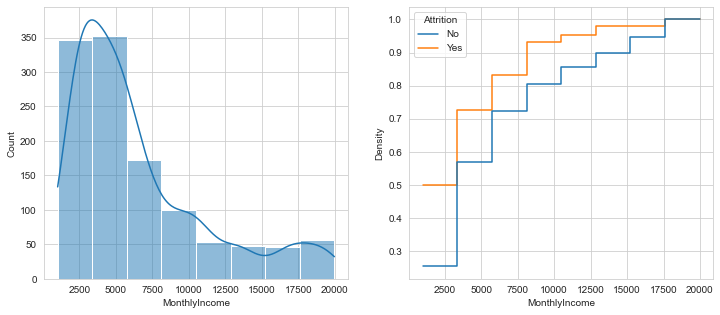

In [191]:
fig, ax =plt.subplots(1,2,figsize=(12, 5))
# histogram of monthly income
sns.histplot(x='MonthlyIncome', kde=True, data=train, bins = 8, ax=ax[0])
# monthly income histogram by target
sns.histplot(x='MonthlyIncome', hue='Attrition', cumulative= True, bins = 8,
             element="step", fill=False, stat="density",
             common_norm=False, data=train, ax=ax[1]);

#### DailyRate
We see a unifoorm distribution for daily rate.
Again those with lower daily rate are more likely to leave the company.

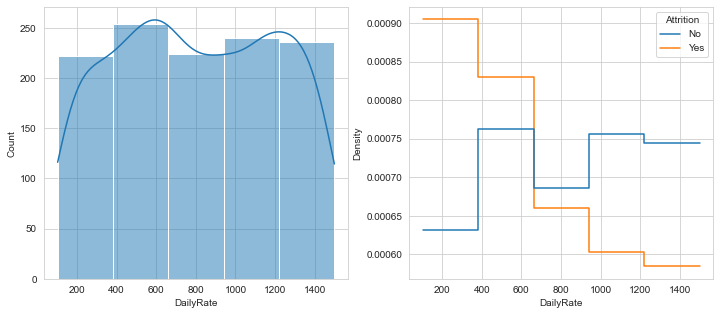

In [192]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
# histogram of DailyRate
sns.histplot(x='DailyRate', kde=True, data=train, bins=5, ax=ax[0])
# age histogram by target
sns.histplot(x='DailyRate', hue='Attrition', cumulative=False, bins=5,
             element="step", fill=False, stat="density",
             common_norm=False, data=train, ax=ax[1]);

#### EmployeeNumber
The distribution is rather uniform.
What we see is that the most attrition is in midsized units.


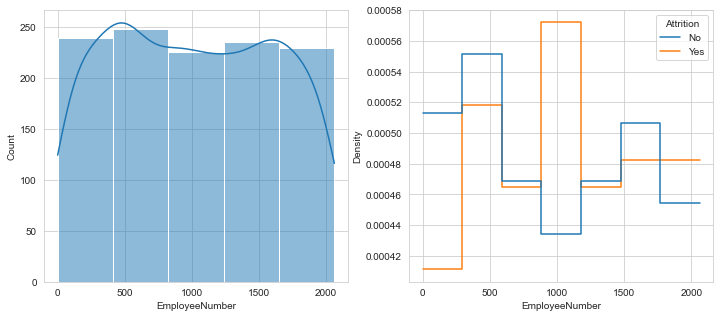

In [193]:
fig, ax =plt.subplots(1,2,figsize=(12, 5))
# histogram of age
sns.histplot(x='EmployeeNumber', kde=True, data=train, bins=5, ax=ax[0])
# age histogram by target
sns.histplot(x='EmployeeNumber', hue='Attrition', cumulative= False,
             bins=7, element="step", fill=False, stat="density",
             common_norm=False, data=train, ax=ax[1]);

#### Distance From Home
As one would expect those who are closer to their workplace are less likley to leave.


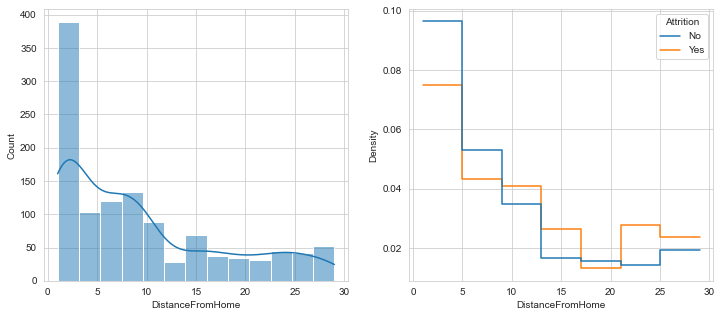

In [194]:
fig, ax =plt.subplots(1,2,figsize=(12, 5))
# histogram of distance from home
sns.histplot(x='DistanceFromHome', kde=True, data=train, ax=ax[0])
# distance from home histogram by target
sns.histplot(x='DistanceFromHome', hue='Attrition', cumulative= False, bins = 7,
             element="step", fill=False, stat="density",
             common_norm=False, data=train, ax=ax[1]);

#### Age
Age has an almost normal distrbution and as we can see the younger employees are more likely to leave the company.

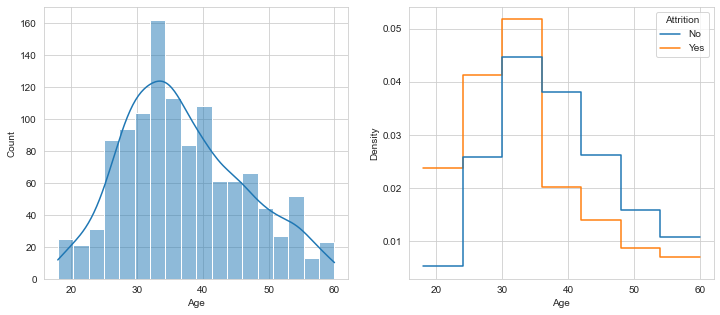

In [195]:
fig, ax =plt.subplots(1,2,figsize=(12, 5))
# histogram of age
sns.histplot(x='Age', kde=True, data=train, ax=ax[0])
# age histogram by target
sns.histplot(x='Age', hue='Attrition', cumulative= False, bins=7,
             element="step", fill=False, stat="density",
             common_norm=False, data=train, ax=ax[1]);

## Education

<AxesSubplot:xlabel='Education', ylabel='Density'>

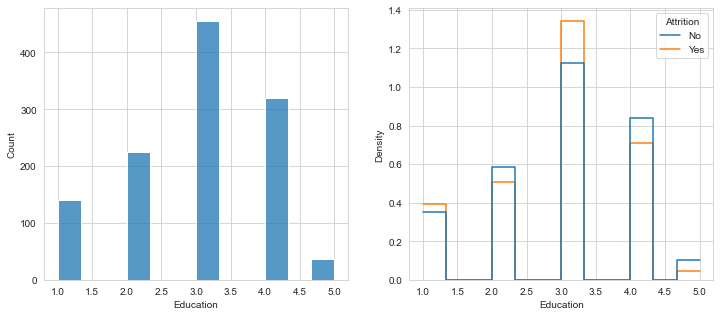

In [197]:
fig, ax =plt.subplots(1,2,figsize=(12, 5))
# histogram of education
sns.histplot(x='Education', kde=False, data=train, ax=ax[0])
# education histogram by target
sns.histplot(x='Education', hue='Attrition', cumulative= False,
             element="step", fill=False, stat="density",
             common_norm=False, data=train, ax=ax[1])

# 4- Data Preprocessing

I am going to encode the categorical variables using target encoding and one hot encoding.

In [ ]:
X_train = train.drop(['Attrition'], axis=1)
y_train = train['Attrition'].map({'Yes': 1, 'No': 0})
X_test = test.drop(['Attrition'], axis=1)
y_test = test['Attrition'].map({'Yes': 1, 'No': 0})

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from category_encoders import WOEEncoder
from copy import deepcopy
import joblib

'''Save original columns that need to be droped or not used
   Save One-hot and Label encoders for future use
'''
#Columns to drop from ML models
cols_to_drop = []
#Categorical encoders disctionary
cat_encoders = {}
#New categorical (encoded) columns
cat_enc_columns = []

for col in X_train.columns:
    if X_train[col].dtype == 'object':
        if X_train[col].nunique() == 2:
            print("One-hot encoding of ", col)
            enc = OneHotEncoder( handle_unknown='ignore', drop= 'if_binary', sparse=False)
            enc.fit(X_train[[col]])
            joblib.dump(enc, col + '_enc.joblib')
            result = enc.transform(X_train[[col]])
            ohe_columns = [col+"_"+str(x) for x in enc.categories_[0][1:]]
            cat_enc_columns = cat_enc_columns + ohe_columns
            result_train = pd.DataFrame(result, columns=ohe_columns , index=X_train.index)
            X_train = pd.concat([X_train, result_train.reindex(X_train.index)], axis=1 , join='inner')
            '''Encode Testing'''
            result = enc.transform(X_test[[col]])
            result_test = pd.DataFrame(result, columns=ohe_columns , index=X_test.index)
            X_test = pd.concat([X_test, result_test.reindex(X_test.index)], axis=1 , join='inner')
            cat_encoders[col] = [deepcopy(enc),"ohe"]
        elif X_train[col].nunique() < 10:
            print("One-hot encoding of ", col)
            enc = OneHotEncoder( handle_unknown='ignore', sparse=False)
            enc.fit(X_train[[col]])
            joblib.dump(enc, col + '_enc.joblib')
            result = enc.transform(X_train[[col]])
            ohe_columns = [col+"_"+str(x) for x in enc.categories_[0]]
            cat_enc_columns = cat_enc_columns + ohe_columns
            result_train = pd.DataFrame(result, columns=ohe_columns , index=X_train.index)
            X_train = pd.concat([X_train, result_train.reindex(X_train.index)], axis=1 , join='inner')
            '''Encode Testing'''
            result = enc.transform(X_test[[col]])
            result_test = pd.DataFrame(result, columns=ohe_columns , index=X_test.index)
            X_test = pd.concat([X_test, result_test.reindex(X_test.index)], axis=1 , join='inner')
            cat_encoders[col] = [deepcopy(enc),"ohe"]
        else:
            print("WOEEncoder Encoding of ", col)
            enc = WOEEncoder()
            enc.fit(X_train[col] , y = y_train , handle_unknown='value' )
            dill.dump(enc, open(col+'_trg_'+'pre_processing.p', "wb"))
            new_col_name = col+"_trg"
            X_train[new_col_name] = enc.transform(X_train[[col]])
            X_test[new_col_name] = enc.transform(X_test[[col]])
            cat_encoders[col] = [deepcopy(enc),"trg"]
            cat_enc_columns.append(new_col_name)


        cols_to_drop.append(col)

X_train.drop(cols_to_drop, axis=1, inplace=True)
X_test.drop(cols_to_drop, axis=1, inplace=True)

In [ ]:
X_train.to_csv('X_train.csv', index=False, header=True)
X_test.to_csv('X_test.csv', index=False, header=True)
y_train.to_csv('y_train.csv', index=False, header=True)
y_test.to_csv('y_test.csv', index=False, header=True)

In [198]:
X_train = pd.read_csv('X_train.csv',header=0)
X_test = pd.read_csv('X_test.csv',header=0)
y_train = pd.read_csv('y_train.csv',header=0)
y_test = pd.read_csv('y_test.csv',header=0)

# 5- Modeling

I am going to stack a combination of gradient boosting methods.

#### 5.1- XGBoost

In [201]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, loguniform, randint
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, confusion_matrix
from xgboost import plot_importance

In [ ]:
# scale_pos_weight = total_negative_examples / total_positive_examples
round((y_train== 0).astype(int).sum() / (y_train== 1).astype(int).sum(),2)

In [ ]:
#xgboost search space
params = {'n_estimators': [100, 200, 500, 1000, 1500],
          'gamma': loguniform(0.01, 1.0,), #default = 0, range: [0,∞]
          'learning_rate': loguniform(1e-3, 1), #default = 0.3, range: [0,1]
          'max_depth': randint(3, 10), #default = 6, range: [0,∞]
          'min_child_weight': randint(1, 10), # default = 1, range: [0,∞] The larger, the more conservative
          #'subsample': uniform(.5, .4), # scipy [loc, loc + scale]. default = 1, range: (0,1], prevents overfitting
          'reg_lambda': loguniform(1e-9, 100.0), # default = 1, range: [0,∞], L2
          #'reg_alpha': loguniform(1e-9, 100.0), # default = 0, range: [0,∞], L1
          'scale_pos_weight': [1, 3, 5, 12, 25]}

In [ ]:
#xgboost grid search
xgb_grid = RandomizedSearchCV(XGBClassifier(), params, scoring= 'roc_auc' , n_iter=16, cv=5, verbose=1, random_state=42)
xgb_grid.fit(X_train, y_train)
xgb_grid.best_params_

In [ ]:
opt_xgb = XGBClassifier(**xgb_grid.best_params_)
opt_xgb.fit(X_train, y_train)

In [ ]:
train_pred = opt_xgb.predict(X_train)
test_pred = opt_xgb.predict(X_test)
print('train auc:', roc_auc_score(y_train, train_pred))
print('test auc:', roc_auc_score(y_test, test_pred))

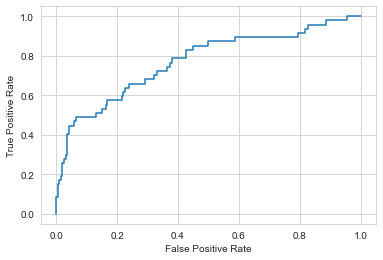

In [202]:
#define metrics
y_pred_proba = opt_xgb.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [203]:
train_pred = opt_xgb.predict(X_train)
test_pred = opt_xgb.predict(X_test)
print('train MSE:', mean_squared_error(y_train, train_pred))
print('test MSE:', mean_squared_error(y_test, test_pred))

train MSE: 0.03486394557823129
test MSE: 0.2108843537414966


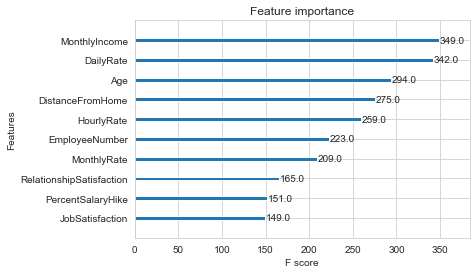

In [204]:
plot_importance(opt_xgb, max_num_features=10);

In [205]:
confusion_matrix(y_train, opt_xgb.predict_proba(X_train)[:,1]>.83)

array([[984,   2],
       [  2, 188]], dtype=int64)

In [206]:
tn, fp, fn, tp = confusion_matrix(y_train, opt_xgb.predict_proba(X_train)[:,1]>.81).ravel()
tn, fp, fn, tp

(983, 3, 1, 189)

In [207]:
confusion_matrix(y_test, opt_xgb.predict_proba(X_test)[:,1]>.83)

array([[242,   5],
       [ 35,  12]], dtype=int64)

In [ ]:
dill.dump(opt_xgb, open('opt_xgb.p', "wb"))

In [199]:
opt_xgb = dill.load(open('opt_xgb.p', "rb"))

#### 5.2- Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#random forest search space
params = {'n_estimators': [100, 200, 500, 1000, 1500],
          'max_depth': randint(3, 15),
          'min_samples_split': randint(2, 10),
          'bootstrap': [True, False],
          'criterion': ['gini', 'entropy']}

In [ ]:
#random forest grid search
rf_grid = RandomizedSearchCV(RandomForestClassifier(), params, n_iter=12, cv=4, verbose=1, random_state=42)
rf_grid.fit(X_train, y_train)
rf_grid.best_params_

In [ ]:
opt_rf = RandomForestClassifier(**rf_grid.best_params_)
opt_rf.fit(X_train, y_train)

In [212]:
train_pred = opt_rf.predict(X_train)
test_pred = opt_rf.predict(X_test)
print('train auc:', roc_auc_score(y_train, train_pred))
print('test auc:', roc_auc_score(y_test, test_pred))

train auc: 0.6789473684210526
test auc: 0.5258420191230941


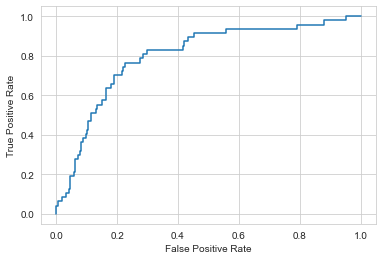

In [213]:
#define metrics
y_pred_proba = opt_rf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [209]:
train_pred = opt_rf.predict(X_train)
test_pred = opt_rf.predict(X_test)
print('train mse:', mean_squared_error(y_train, train_pred))
print('test mse:', mean_squared_error(y_test, test_pred))

train mse: 0.10374149659863946
test mse: 0.1598639455782313


In [210]:
dill.dump(opt_rf, open('opt_rf.p', "wb"))

In [311]:
%%capture
opt_rf = dill.load(open('opt_rf.p', "rb"))

#### 5.3- CatBoost

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
opt_cat = CatBoostClassifier()
opt_cat.fit(X_train, y_train)

In [217]:
train_pred = opt_cat.predict(X_train)
test_pred = opt_cat.predict(X_test)
print('train auc:', roc_auc_score(y_train, train_pred))
print('test auc:', roc_auc_score(y_test, test_pred))

train auc: 0.9605263157894737
test auc: 0.5896718063571367


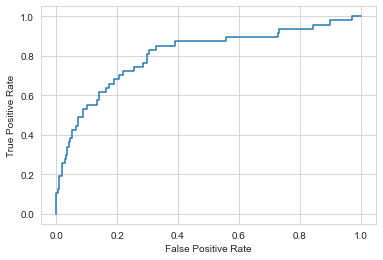

In [216]:
#define metrics
y_pred_proba = opt_cat.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [215]:
train_pred = opt_cat.predict(X_train)
test_pred = opt_cat.predict(X_test)
print('train mse:', mean_squared_error(y_train, train_pred))
print('test mse:', mean_squared_error(y_test, test_pred))

train mse: 0.012755102040816327
test mse: 0.13945578231292516


In [ ]:
dill.dump(opt_cat, open('opt_cat.p', "wb"))

In [214]:
opt_cat = dill.load(open('opt_cat.p', "rb"))

#### 5.4- LightGBM

https://neptune.ai/blog/lightgbm-parameters-guide

In [ ]:
from lightgbm import LGBMClassifier
lgb_clf = LGBMClassifier(objective= 'binary', metric= 'auc', is_unbalance=True, boosting_type= 'gbdt')

In [ ]:
#lightgbm search space
params = {'num_iterations': [100, 200, 500, 1000, 1500],# can be considered as number of trees
        'learning_rate': loguniform(1e-5, 1),
        'max_depth': randint(3, 15),
        'num_leaves': randint(10, 60),
        'feature_fraction': uniform(.5, .4), # scipy [loc, loc + scale].
        'subsample': uniform(.5, .4), # scipy [loc, loc + scale].
        'lambda_l2': loguniform(1e-5, 100),
         }

In [ ]:
%%capture
#lightgbm grid search
lgb_grid = RandomizedSearchCV(lgb_clf, params, n_iter=12, cv=5, verbose=1, random_state=42)
lgb_grid.fit(X_train, y_train)
lgb_grid.best_params_

In [ ]:
lgb_grid.best_params_

In [ ]:
opt_lgb = LGBMClassifier(**lgb_grid.best_params_)
opt_lgb.fit(X_train, y_train)

In [221]:
train_pred = opt_lgb.predict(X_train)
test_pred = opt_lgb.predict(X_test)
print('train auc:', roc_auc_score(y_train, train_pred))
print('test auc:', roc_auc_score(y_test, test_pred))

train auc: 1.0
test auc: 0.6175381169782066


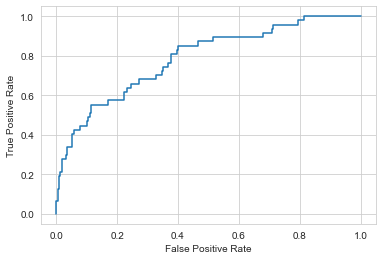

In [220]:
#define metrics
y_pred_proba = opt_lgb.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [219]:
train_pred = opt_lgb.predict(X_train)
test_pred = opt_lgb.predict(X_test)
print('train MSE:', mean_squared_error(y_train, train_pred))
print('test MSE:', mean_squared_error(y_test, test_pred))

train MSE: 0.0
test MSE: 0.1360544217687075


In [ ]:
dill.dump(opt_lgb, open('opt_lgb.p', "wb"))

In [218]:
%%capture
opt_lgb = dill.load(open('opt_lgb.p', "rb"))

Trying to unpickle estimator LabelEncoder from version 1.1.1 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations


#### 5.5- Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
log = LogisticRegression( max_iter=1000)

In [ ]:
params = {'C': loguniform(1e-5, 1),
          'penalty': ['l1', 'l2'],
          'tol': loguniform(1e-5, 1),
          'class_weight': ['balanced', None],
          'solver': ['lbfgs', 'liblinear', 'sag', 'saga']}

In [ ]:
%%capture
log_grid = RandomizedSearchCV(log, params, n_iter=12, cv=4, verbose=1, random_state=42)
log_grid.fit(X_train, y_train)
log_grid.best_params_

In [ ]:
opt_log = LogisticRegression(**log_grid.best_params_)
opt_log.fit(X_train, y_train)

In [226]:
train_pred = opt_log.predict(X_train)
test_pred = opt_log.predict(X_test)
print('train auc:', roc_auc_score(y_train, train_pred))
print('test auc:', roc_auc_score(y_test, test_pred))

train auc: 0.510019216397993
test auc: 0.5106382978723404


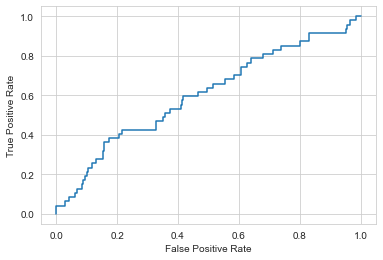

In [225]:
#define metrics
y_pred_proba = opt_log.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [223]:
train_pred = opt_log.predict(X_train)
test_pred = opt_log.predict(X_test)
print('train mse:', mean_squared_error(y_train, train_pred))
print('test mse:', mean_squared_error(y_test, test_pred))

train mse: 0.15901360544217688
test mse: 0.1564625850340136


In [ ]:
dill.dump(opt_log, open('opt_log.p', "wb"))

In [222]:
opt_log = dill.load(open('opt_log.p', "rb"))

Trying to unpickle estimator LogisticRegression from version 1.1.1 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations


#### 5.6- Stacking

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

In [ ]:
stack_log = LogisticRegression()
estimators=[('rf',opt_rf),
            ('lgb',opt_lgb),
            ('cat',opt_cat),
            ('xgb',opt_xgb),
            ('log',opt_log)]
stack = StackingClassifier(estimators=estimators,
                           final_estimator=stack_log)

In [ ]:
%%capture
stack.fit(X_train, y_train)

In [227]:
train_pred = stack.predict(X_train)
test_pred = stack.predict(X_test)
print('train auc:', roc_auc_score(y_train, train_pred))
print('test auc:', roc_auc_score(y_test, test_pred))

train auc: 0.9763157894736842
test auc: 0.6089241106038419


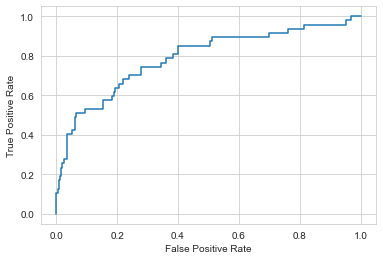

In [142]:
#define metrics
y_pred_proba = stack.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [228]:
train_pred = stack.predict(X_train)
test_pred = stack.predict(X_test)
print('train mse:', mean_squared_error(y_train, train_pred))
print('test mse:', mean_squared_error(y_test, test_pred))

train mse: 0.007653061224489796
test mse: 0.1360544217687075


In [ ]:
dill.dump(stack, open('stack.p', "wb"))

In [ ]:
stack = dill.load(open('stack.p', "rb"))

In [5]:
X_train = pd.read_csv('X_train.csv',header=0)
X_test = pd.read_csv('X_test.csv',header=0)
y_train = pd.read_csv('y_train.csv',header=0)
y_test = pd.read_csv('y_test.csv',header=0)

# 6- Global Model-Agnostic Methods
<a id='cell_6'></a>

https://christophm.github.io/interpretable-ml-book/global-methods.html

# 6.1- Partial Dependence Plots
<a id='cell_6_1'></a>

https://christophm.github.io/interpretable-ml-book/pdp.html
- Partial dependence plot show the expected prediction of a predictor, when all other features are marginalized out.
- Since global interpretation methods describe average behavior, they are particularly useful when the modeler wants to understand the general mechanisms in the data or debug a model.
- An assumption of the PDP is that the features in C are not correlated with the features in S. If this assumption is violated, the averages calculated for the partial dependence plot will include data points that are very unlikely or even impossible.
- An easy way to deal with multiple classes is to draw one line or plot per class.
- For categorical features, the partial dependence is estimated by forcing all data instances to have the same category. For example to compute the value for "summer", we replace the season of all data instances with "summer" and average the predictions.
- A feature could be very important based on other methods such as permutation feature importance, but the PDP could be flat as the feature affects the prediction mainly through interactions with other features.
- Another drawback of this measure is that it is defined over the unique values. A unique feature value with just one instance is given the same weight in the importance computation as a value with many instances.
- Assumption of independence, for example, suppose you want to predict how fast a person walks, given the person's weight and height. For the partial dependence of one of the features, e.g. height, we assume that the other features (weight) are not correlated with height, which is obviously a false assumption. For the computation of the PDP at a certain height (e.g. 200 cm), we average over the marginal distribution of weight, which might include a weight below 50 kg, which is unrealistic for a 2 meter person.
- Heterogeneous effects might be hidden because PD plots only show the average marginal effects. Suppose that for a feature half your data points have a positive association with the prediction -- the larger the feature value the larger the prediction -- and the other half has a negative association -- the smaller the feature value the larger the prediction.

In [229]:
from sklearn.inspection import PartialDependenceDisplay

done in 14.208s


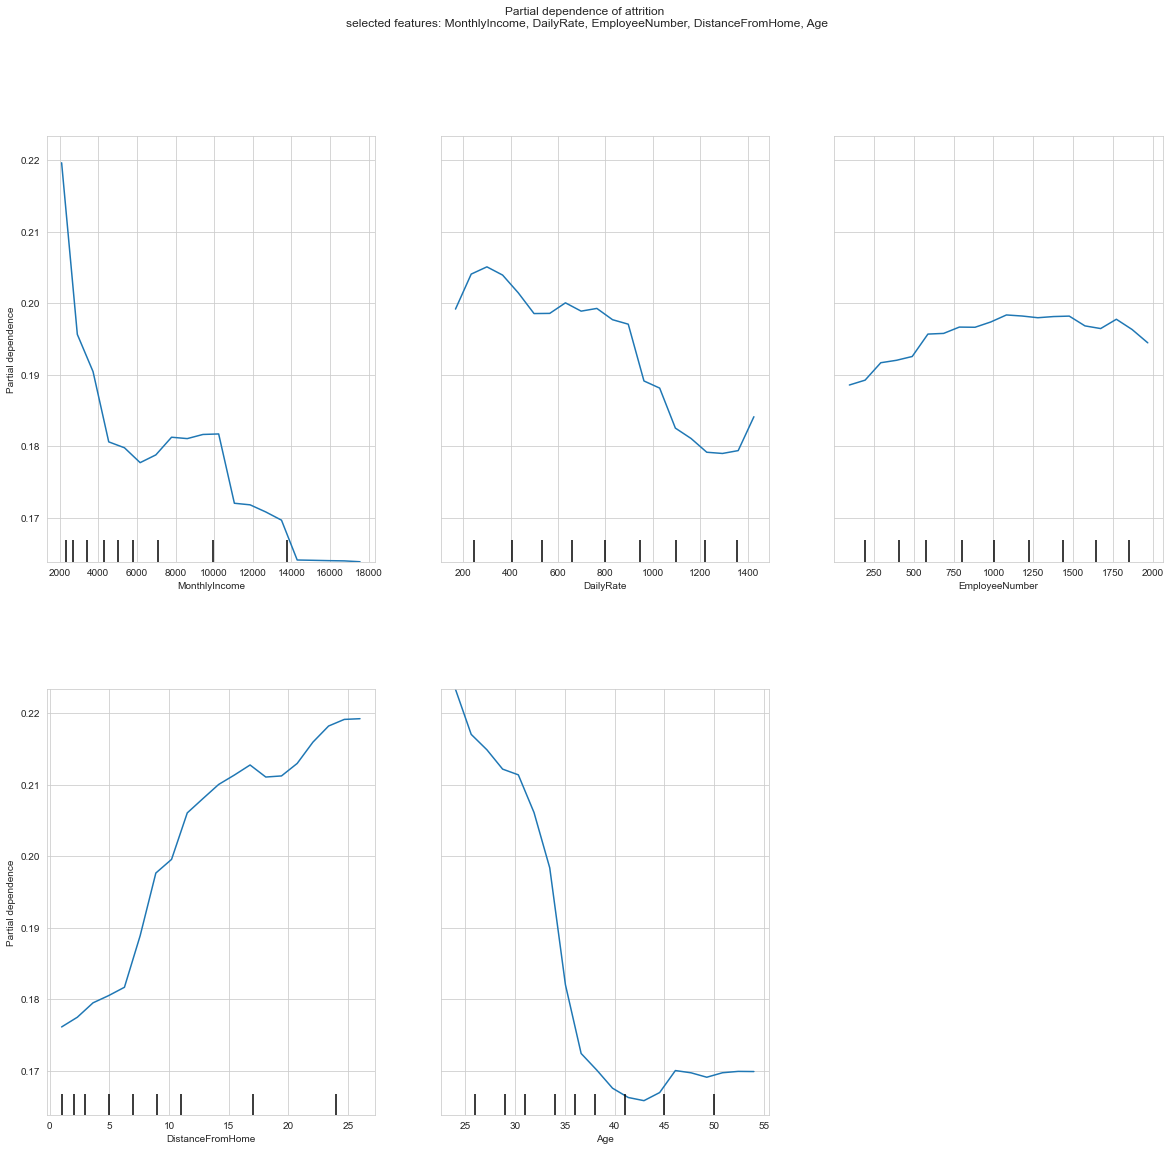

In [235]:
plt.rcParams['figure.figsize'] = [20, 18]

common_params = {
    #"subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 20,
    #"centered": True,
    "random_state": 0,
}
tic = time()
display = PartialDependenceDisplay.from_estimator(
    stack,
    X_train,
    features=["MonthlyIncome", "DailyRate", "EmployeeNumber", "DistanceFromHome",'Age'],
    kind="average",
    **common_params,
)
print(f"done in {time() - tic:.3f}s")
display.figure_.suptitle(
    "Partial dependence of attrition \n"
    "selected features: MonthlyIncome, DailyRate, EmployeeNumber, DistanceFromHome, Age"
)
display.figure_.subplots_adjust(hspace=0.3)

done in 0.983s


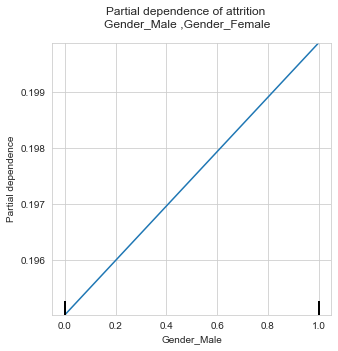

In [237]:
plt.rcParams['figure.figsize'] = [5, 5]

common_params = {
    #"subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 20,
#    "centered": True,
    "random_state": 0,
}
tic = time()
display = PartialDependenceDisplay.from_estimator(
    stack,
    X_train,
    features=['Gender_Male'],
    kind="average",
    **common_params,
)
print(f"done in {time() - tic:.3f}s")
display.figure_.suptitle(
    "Partial dependence of attrition \n"
    "Gender_Male ,Gender_Female"
)
display.figure_.subplots_adjust(hspace=0.3)

In [ ]:
%%capture
plt.rcParams['figure.figsize'] = [15, 9]

common_params = {
    #"subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 20,
    #    "centered": True,
    "random_state": 0,
}
tic = time()
display = PartialDependenceDisplay.from_estimator(
    stack,
    X_train,
    features=["Age", "MonthlyIncome",("MonthlyIncome","Age")],
    kind=["average", "average", "average"],
    **common_params,
)
print(f"done in {time() - tic:.3f}s")
display.figure_.suptitle(
    "Partial dependence of attrition \n"
    "Gender_Male ,Gender_Female"
)
display.figure_.subplots_adjust(hspace=0.3)

As mentioned in this chapter summary, PDP can lead to misleading result when there is interaction between feautres. Here we see that adding age gives us a more detailed look at how income is affecting probabilty of attrition. The following regression which certainly suffer from endogeneity, hints the relationship between income and age and age's explanatory power.

# 6.2- Accumulated Local Effects(ALE) Plots
<a id='cell_6_2'></a>

#### Interpretable Machine Learning
https://christophm.github.io/interpretable-ml-book/ale.html

The main problem with PDP is that the predictor of interest might be correlated with other predictors.
The other problem is that it is very possible that it would go outside the distribution of training data to make a prediction, and since the model is not penalized for doing weird stuff in these areas, the extraploation is very likely to lead to strange results.

The interpretation of ALE plots is clear: Conditional on a given value, the relative effect of changing the feature on the prediction can be read from the ALE plot. ALE plots are centered at zero. This makes their interpretation nice, because the value at each point of the ALE curve is the difference to the mean prediction. The 2D ALE plot only shows the interaction: If two features do not interact, the plot shows nothing.

Second-order effect plots can be a bit annoying to interpret, as you always have to keep the main effects in mind.

Advantages:
ALE plots are unbiased, meaning they work with correlated features.
ALE plots are computationally fast to compute.
The interpretation of the ALE plot is clear.

Disadvantages:
The implementation of ALE plots is complicated and difficult to understand.
Interpretation still remains difficult if features are strongly correlated.
The main disadvantage comes from the problem of sparsity of data. There needs to be sufficient number of observations in each neighborhood that is used in order to make a reasonable estimation. Specially it could be exuberated with additional dimentionality of the data.
There is no perfect solution for setting the number of intervals. If the number is too small, the ALE plots might not be very accurate. If the number is too high, the curve can become shaky.
Second-order ALE estimates have a varying stability across the feature space, which is not visualized in any way. The reason for this is that each estimation of a local effect in a cell uses a different number of data instances. As a result, all estimates have a different accuracy (but they are still the best possible estimates).

#### Oracle documentation
Calculation:
https://docs.oracle.com/en-us/iaas/tools/ads-sdk/latest/user_guide/mlx/accumulated_local_effects.html
For each interval, MLX approximates the conditional distribution by identifying the samples that are in the neighborhood of the sample of interest. It then calculates the difference in the model prediction when the selected feature’s value of the samples is replaced by the upper and lower limits of the interval. If N different intervals are selected from the feature’s distribution, this process results in 2N different augmented datasets It is 2N as each selected feature of the sample are replaced with the upper and lower limits of the interval. The model inference then generates 2N different model predictions, which are used to calculate the N differences.
The prediction differences within each interval are averaged and accumulated in order, such that the ALE of a feature value that lies in the k-th interval is the sum of the effects of the first through the k-th interval.
Finally, the accumulated feature effects at each interval is centered, such that the mean effect is zero.

#### Youtube presentation by the author
Interpreting Black-Box Supervised Learning Models Via Accumulated Local Effects
INFORMS-QSR and ENBIS Webinar Series Presents: Prof. Dan Apley
https://www.youtube.com/watch?v=06knUxoig9Y

#### alibi ALE Documentation
https://docs.seldon.io/projects/alibi/en/stable/methods/ALE.html

https://docs.seldon.io/projects/alibi/en/stable/examples/ale_classification.html

#### kaggle notebook that I got the code impleamentation from
https://www.kaggle.com/code/smitisinghal/visualization-on-heart-disease-dataset-xai?scriptVersionId=73215961

## 6.2.1- Stacked model - Accumulated Local Effects (ALE) Plots

In [247]:
%%capture
#as we are going to use only values from X_train, the sklearn is going to raise error
from alibi.explainers import ALE, plot_ale

feature_names = [i for i in X_train.columns]
proba_fun_stack = stack.predict_proba

ale = ALE(proba_fun_stack, feature_names= feature_names , target_names= [0,1])
stack_explained = ale.explain(X_train.values)

In [249]:
# the feature list should be the index number of the columns
exp_features = []
for i in ["MonthlyIncome", "DailyRate", "EmployeeNumber", "DistanceFromHome",'Age', 'Gender_Male']:
    exp_features.append(X_train.columns.get_loc(i))

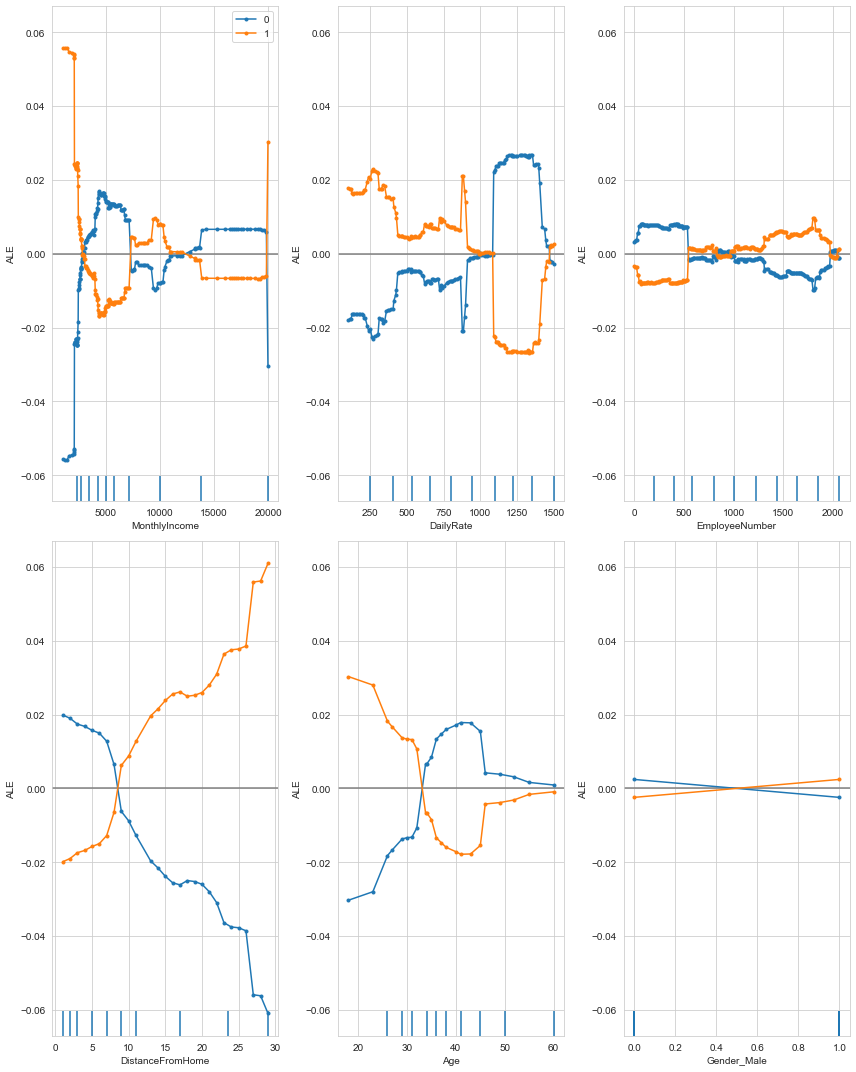

In [250]:
plot_ale(stack_explained, features=exp_features , n_cols=3, fig_kw={'figwidth': 12, 'figheight': 15});

## 6.2.2 - Model comparison

In this part I am going to compare how each of the base models are being affected by the independent variables. We can clearly see that the stack model is an average of the base models. And we can also see the leanear trend in the logistic regression and the step pattern for the tree models.

In [251]:
from alibi.explainers import ALE, plot_ale

In [252]:
feature_names = [i for i in X_train.columns]

#### XGBoost

In [253]:
opt_xgb = dill.load(open('opt_xgb.p', "rb"))

In [254]:
proba_fun_xgb = opt_xgb.predict_proba

ale = ALE(proba_fun_xgb, feature_names= feature_names , target_names= [0,1])
xgb_explained = ale.explain(X_train.values)

#### Logistic Regression

In [313]:
%%capture
opt_log = dill.load(open('opt_log.p', "rb"))

In [256]:
%%capture
proba_fun_log = opt_log.predict_proba

ale = ALE(proba_fun_log, feature_names= feature_names , target_names= [0,1])
log_explained = ale.explain(X_train.values)

In [257]:
%%capture
proba_fun_lgb = opt_lgb.predict_proba

ale = ALE(proba_fun_lgb, feature_names=feature_names, target_names=[0, 1])
lgb_explained = ale.explain(X_train.values)

#### Graphs

In [258]:
# the feature list should be the index number of the columns
exp_features = []
for i in ["MonthlyIncome", "DailyRate"]:
    exp_features.append(X_train.columns.get_loc(i))

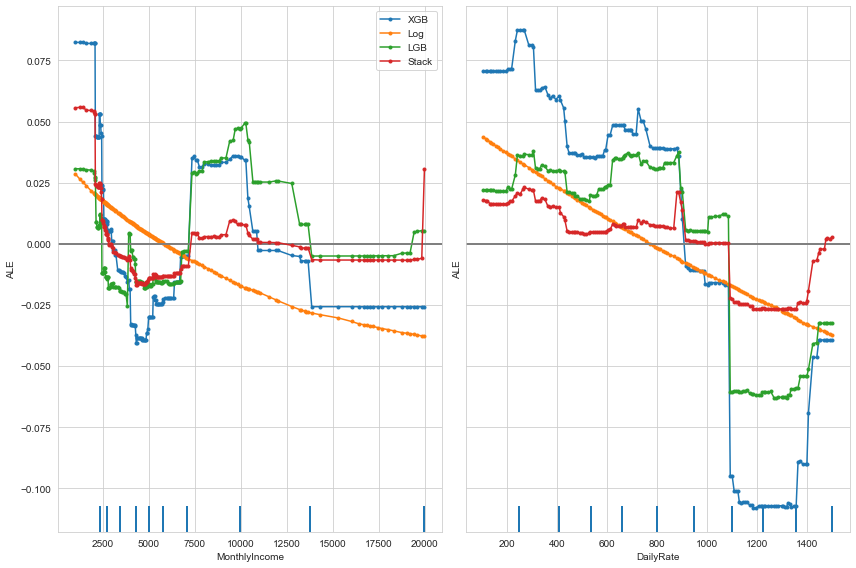

In [259]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey='row');
plot_ale(xgb_explained, features=exp_features, targets=[1], ax=ax, line_kw={'label': 'XGB'});
plot_ale(log_explained, features=exp_features, targets=[1], ax=ax, line_kw={'label': 'Log'});
plot_ale(lgb_explained, features=exp_features, targets=[1], ax=ax, line_kw={'label': 'LGB'});
plot_ale(stack_explained, features=exp_features, targets=[1], ax=ax, line_kw={'label': 'Stack'});

The plot is indeed very crowded, but it shows how the stack model is averaging the predictions over first layer model.

#### ALE Interaction
at the moment there is no package for inspecting ALE of feature interactions.

# 6.3- Feature Interaction
<a id='cell_6_3'></a>

- https://christophm.github.io/interpretable-ml-book/interaction.html


- One way to estimate the interaction strength is to measure how much of the variation of the prediction depends on the interaction of the features. This measurement is called H-statistic, introduced by Friedman and Popescu
- The H-statistic is expensive to evaluate, because it iterates over all data points and at each point the partial dependence has to be evaluated which in turn is done with all n data points. In the worst case, we need 2n2 calls to the machine learning models predict function to compute the two-way H-statistic (j vs. k) and 3n2 for the total H-statistic (j vs. all).

Advantages:
- The interaction H-statistic has an underlying theory through the partial dependence decomposition.
- The H-statistic has a meaningful interpretation: The interaction is defined as the share of variance that is explained by the interaction.
- Since the statistic is dimensionless, it is comparable across features and even across models.
- The statistic detects all kinds of interactions, regardless of their particular form.
- With the H-statistic it is also possible to analyze arbitrary higher interactions such as the interaction strength between 3 or more features.

Disadvantages:
- The interaction H-statistic takes a long time to compute, because it is computationally expensive.
- The computation involves estimating marginal distributions. These estimates also have a certain variance if we do not use all data points. This means that as we sample points, the estimates also vary from run to run and the results can be unstable. I recommend repeating the H-statistic computation a few times to see if you have enough data to get a stable result.

A meaningful workflow is to measure the interaction strengths and then create 2D-partial dependence plots for the interactions you are interested in.


There is no python package for this part, in the far future, in a galaxy far far away I will later add the R code.

# 6.4- Functional Decompositon
<a id='cell_6_4'></a>
better to read the book

# 6.5- Permutation Feature Importance
<a id='cell_6_5'></a>

- https://christophm.github.io/interpretable-ml-book/feature-importance.html
- Permutation feature importance measures the increase in the prediction error of the model after we permuted the feature's values, which breaks the relationship between the feature and the true outcome.
- A feature is "important" if shuffling its values increases the model error, because in this case the model relied on the feature for the prediction.
- Should I Compute Importance on Training or Test Data?
tl;dr: You should probably use test data.

 Advantages:
- Nice interpretation: Feature importance is the increase in model error when the feature's information is destroyed.
- Feature importance provides a highly compressed, global insight into the model's behavior.
- A positive aspect of using the error ratio instead of the error difference is that the feature importance measurements are comparable across different problems.
- The importance measure automatically takes into account all interactions with other features. By permuting the feature you also destroy the interaction effects with other features. This is also a disadvantage because the importance of the interaction between two features is included in the importance measurements of both features. This means that the feature importances do not add up to the total drop in performance, but the sum is larger. Only if there is no interaction between the features, as in a linear model, the importances add up approximately.

Disadvantages
- Permutation feature importance is linked to the error of the model. This is not inherently bad, but in some cases not what you need. In some cases, you might prefer to know how much the model's output varies for a feature without considering what it means for performance. For example, you want to find out how robust your model's output is when someone manipulates the features. In this case, you would not be interested in how much the model performance decreases when a feature is permuted, but how much of the model's output variance is explained by each feature.
- The permutation feature importance depends on shuffling the feature, which adds randomness to the measurement. When the permutation is repeated, the results might vary greatly. Repeating the permutation and averaging the importance measures over repetitions stabilizes the measure, but increases the time of computation.
- If features are correlated, the permutation feature importance can be biased by unrealistic data instances. In other words, for the permutation feature importance of a correlated feature, we consider how much the model performance decreases when we exchange the feature with values we would never observe in reality. Check if the features are strongly correlated and be careful about the interpretation of the feature importance if they are. However, pairwise correlations might not be sufficient to reveal the problem.
- Feature Engineering, Adding a correlated feature can decrease the importance of the associated feature by splitting the importance between both features.  I train a random forest and it turns out that the temperature is the most important feature and all is well. Now imagine another scenario in which I additionally include the temperature at 9:00 AM as a feature that is strongly correlated with the temperature at 8:00 AM. The temperature at 9:00 AM does not give me much additional information if I already know the temperature at 8:00 AM. But having more features is always good, right? I train a random forest with the two temperature features and the uncorrelated features. Some of the trees in the random forest pick up the 8:00 AM temperature, others the 9:00 AM temperature, again others both and again others none. The two temperature features together have a bit more importance than the single temperature feature before, but instead of being at the top of the list of important features, each temperature is now somewhere in the middle.

- A model-agnostic alternative to permutation feature importance are variance-based measures. Variance-based feature importance measures such as Sobol's indices or functional ANOVA give higher importance to features that cause high variance in the prediction function. Also SHAP importance has similarities to a variance-based importance measure. If changing a feature greatly changes the output, then it is important. This definition of importance differs from the loss-based definition as in the case of permutation feature importance. This is evident in cases where a model overfitted. If a model overfits and uses a feature that is unrelated to the output, then the permutation feature importance would assign an importance of zero because this feature does not contribute to producing correct predictions. A variance-based importance measure, on the other hand, might assign the feature high importance as the prediction can change a lot when the feature is changed.

About negative values: The model accuracy increases with the shuffle which means the model does not benefit from this value, this is most of the time a result of small datasets. One should beware that the shuffling is performed for one feature at a time, and although a feature might seem unnecessary or less important because of its low (or negative) importance score, it could be the case that it is correlated to other features that can still produce a ‘good’ performance result.

- https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py
- https://www.geeksforgeeks.org/machine-learning-explainability-using-permutation-importance/
- https://docs.oracle.com/en-us/iaas/tools/ads-sdk/latest/user_guide/mlx/permutation_importance.html

In [260]:
from sklearn.inspection import permutation_importance

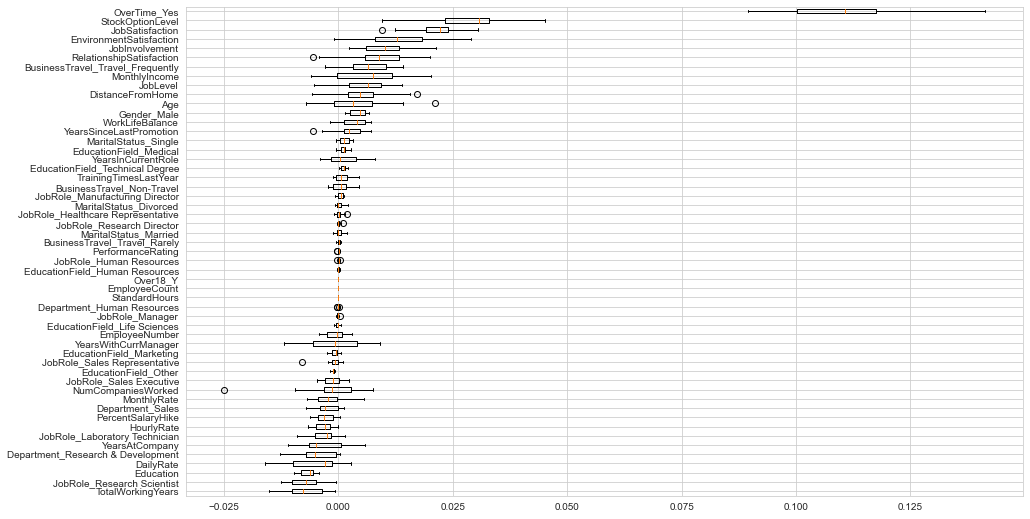

In [261]:
# perform permutation importance
results = permutation_importance(stack, X_test, y_test, n_repeats=15, random_state=42, scoring='roc_auc')
# get importance
perm_sorted_idx = results.importances_mean.argsort()
plt.boxplot(results.importances[perm_sorted_idx].T,
            vert=False,
            labels=X_test.columns[perm_sorted_idx])
plt.show()

However we should take in to consideration that the correlation between variables, affect the permutation result. And if we would need to remove at least the variables that have high correlation is they are at the higer or lower end of the graph.

# 6.6- Surrogate Model
<a id='cell_6_6'></a>

- A global surrogate model is an interpretable model that is trained to approximate the predictions of a black box model.
- One way to measure how well the surrogate replicates the black box model is the R-squared measure.

remarks: the problem is that in most case the surrogate models would not be that close to the black box model.

Check the book for more details..

# 6.7- Prototypes and Criticisms
<a id='cell_6_7'></a>

- I n a user study the authors of MMD-critic gave images to the participants, which they had to visually match to one of two sets of images, each representing one of two classes (e.g. two dog breeds). The participants performed best when the sets showed prototypes and criticisms instead of random images of a class.
- You are free to choose the number of prototypes and criticisms.
- MMD-critic works with density estimates of the data. This works with any type of data and any type of machine learning model.
- The algorithm is easy to implement.
- MMD-critic is very flexible in the way it is used to increase interpretability. It can be used to understand complex data distributions. It can be used to build an interpretable machine learning model. Or it can shed light on the decision making of a black box machine learning model.

- To find the prototypes, we can use KNN.
- For crtisim, there is no package, probably it would be best to take a look at the errors.

# 6.8- Individual Conditional Expectation (ICE)
<a id='cell_6_8'></a>

Advantages:
- Individual conditional expectation curves are even more intuitive to understand than partial dependence plots. One line represents the predictions for one instance if we vary the feature of interest.
- Unlike partial dependence plots, ICE curves can uncover heterogeneous relationships.
Disadvantages:
- ICE curves suffer from the same problem as PDPs: If the feature of interest is correlated with the other features, then some points in the lines might be invalid data points according to the joint feature distribution.

In [262]:
from sklearn.inspection import PartialDependenceDisplay

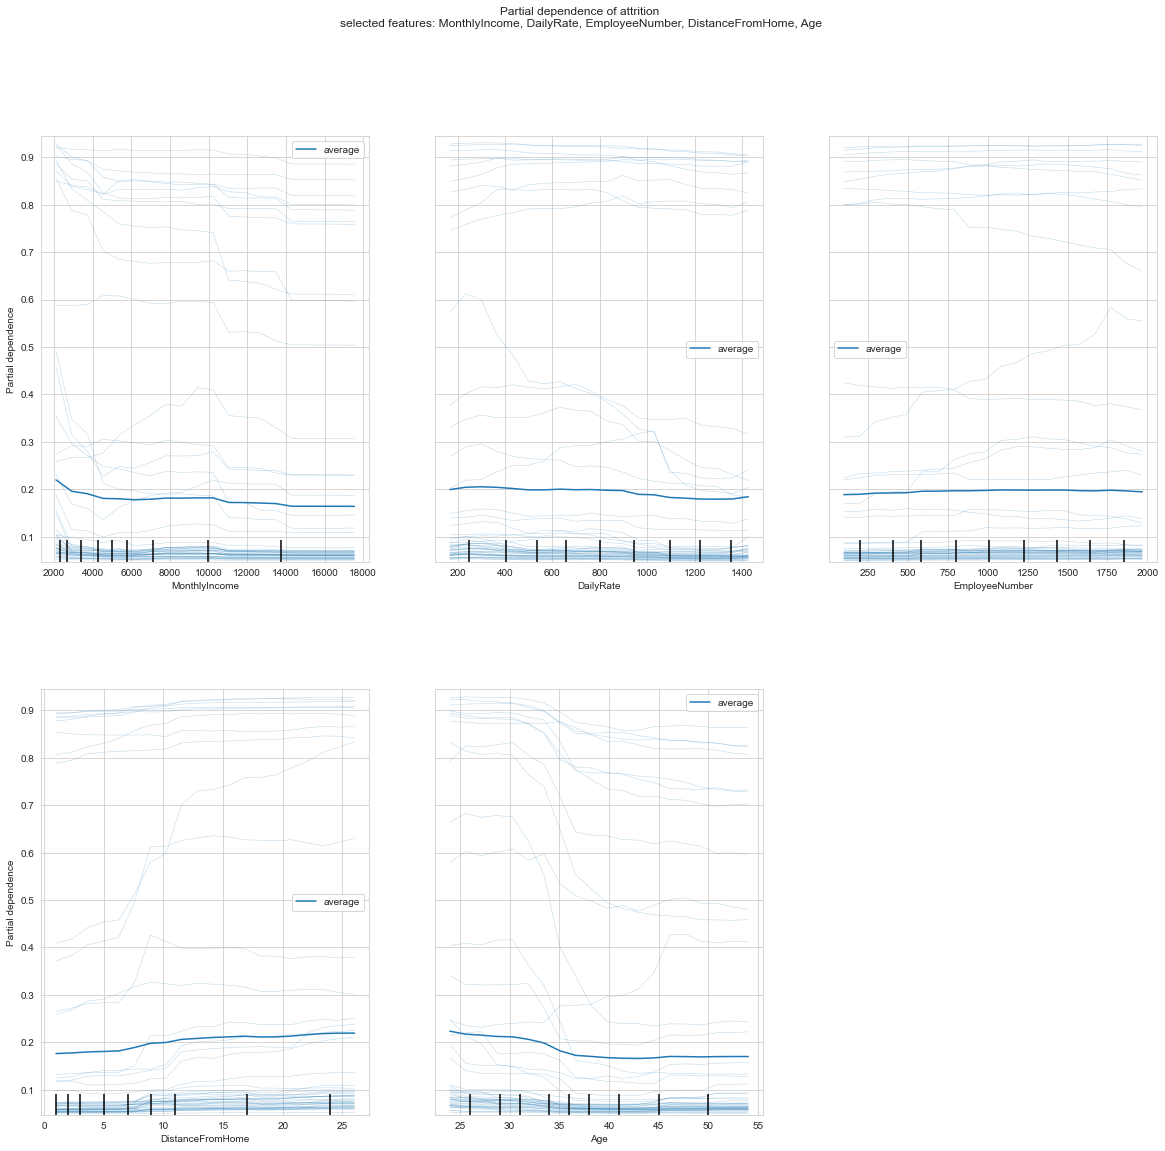

In [264]:
plt.rcParams['figure.figsize'] = [20, 18]

common_params = {
    "subsample": 50,
    "n_jobs": 4,
    "grid_resolution": 20,
#    "centered": True,
    "random_state": 0,
}
tic = time()
display = PartialDependenceDisplay.from_estimator(
    stack,
    X_train,
    features=["MonthlyIncome", "DailyRate", "EmployeeNumber", "DistanceFromHome",'Age'],
    kind="both",
    **common_params,
)

display.figure_.suptitle(
    "Partial dependence of attrition \n"
    "selected features: MonthlyIncome, DailyRate, EmployeeNumber, DistanceFromHome, Age"
)
display.figure_.subplots_adjust(hspace=0.3)

Again, with keeping the possibility of correlatio in mind, we can see that for many of the instances, the model does not depend on the feature of interest. And for the others we can see how individually they affect the model.

# 6.9- Local interpretable model-agnostic explanations - LIME
<a id='cell_6_9'></a>

The recipe for training local surrogate models:

Select your instance of interest for which you want to have an explanation of its black box prediction.
Perturb your dataset and get the black box predictions for these new points.
Weight the new samples according to their proximity to the instance of interest.
Train a weighted, interpretable model on the dataset with the variations.
Explain the prediction by interpreting the local model.

# 6.10- Counterfactual Explanations
<a id='cell_6_10'></a>

- A counterfactual explanation describes a causal situation in the form: "If X had not occurred, Y would not have occurred".
- Unlike prototypes, counterfactuals do not have to be actual instances from the training data, but can be a new combination of feature values.

Advantages:
- The interpretation of counterfactual explanations is very clear. If the feature values of an instance are changed according to the counterfactual, the prediction changes to the predefined prediction. There are no additional assumptions and no magic in the background. This also means it is not as dangerous as methods like LIME, where it is unclear how far we can extrapolate the local model for the interpretation.
- The counterfactual method creates a new instance, but we can also summarize a counterfactual by reporting which feature values have changed. This gives us two options for reporting our results. You can either report the counterfactual instance or highlight which features have been changed between the instance of interest and the counterfactual instance.
- The counterfactual method does not require access to the data or the model. It only requires access to the model's prediction function, which would also work via a web API, for example. This is attractive for companies which are audited by third parties or which are offering explanations for users without disclosing the model or data. A company has an interest in protecting model and data, because of trade secrets or data protection reasons. Counterfactual explanations offer a balance between explaining model predictions and protecting the interests of the model owner.
- The method works also with systems that do not use machine learning. We can create counterfactuals for any system that receives inputs and returns outputs. The system that predicts apartment rents could also consist of handwritten rules, and counterfactual explanations would still work.
- The counterfactual explanation method is relatively easy to implement, since it is essentially a loss function (with a single or many objectives) that can be optimized with standard optimizer libraries. Some additional details must be taken into account, such as limiting feature values to meaningful ranges (e.g. only positive apartment sizes).

Disadvantages:
- For each instance you will usually find multiple counterfactual explanations (Rashomon effect). This is inconvenient
- most people prefer simple explanations over the complexity of the real world. It is also a practical challenge. Let us say we generated 23 counterfactual explanations for one instance. Are we reporting them all? Only the best? What if they are all relatively "good", but very different? These questions must be answered anew for each project. It can also be advantageous to have multiple counterfactual explanations, because humans then can select the ones that correspond to their previous knowledge.

DICE example notebooks:
- https://github.com/interpretml/DiCE
- https://hub.gke2.mybinder.org/user/interpretml-dice-46jnan3l/notebooks/docs/source/notebooks/DiCE_getting_started.ipynb

In [265]:
import dice_ml
import random

In [266]:
numeric_features = []
for col in data.drop(columns=['Attrition']).columns:
    if pd.api.types.is_numeric_dtype(data[col].dtype):
        numeric_features.append(col)

cat_features = data.columns.difference(numeric_features)

In [295]:
dice_df = X_train.merge(y_train, how='left', right_index=True, left_index=True)

In [299]:
dice_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1176 entries, 0 to 1175
Data columns (total 54 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   Age                                1176 non-null   int64
 1   DailyRate                          1176 non-null   int64
 2   DistanceFromHome                   1176 non-null   int64
 3   Education                          1176 non-null   int64
 4   EmployeeCount                      1176 non-null   int64
 5   EmployeeNumber                     1176 non-null   int64
 6   EnvironmentSatisfaction            1176 non-null   int64
 7   HourlyRate                         1176 non-null   int64
 8   JobInvolvement                     1176 non-null   int64
 9   JobLevel                           1176 non-null   int64
 10  JobSatisfaction                    1176 non-null   int64
 11  MonthlyIncome                      1176 non-null   int64
 12  MonthlyRate         

In [298]:
for col in dice_df.columns:
    if col not in numeric_features:
        dice_df[[col]] = dice_df[[col]].astype('int')

In [300]:
# dice_df = X_train.merge(y_train, how='left', right_index=True, left_index=True)
# Step 1: dice_ml.Data
d = dice_ml.Data(dataframe=dice_df, continuous_features=numeric_features, outcome_name='Attrition')
# Using sklearn backend
m = dice_ml.Model(model=stack, backend="sklearn")
# Using method=random for generating CFs
exp = dice_ml.Dice(d, m, method="random")

In [ ]:
e1 = exp.generate_counterfactuals(X_train[0:2], total_CFs=2,
                                  #features_to_vary=["DailyRate", "JobInvolvement","Age"],
                                  #permitted_range={'age': [20, 30], 'education': ['Doctorate', 'Prof-school']},
                                  desired_class="opposite")
e1.visualize_as_dataframe(show_only_changes=True)

well, the code that worked last week is throwing errors for whatever reason. :))) good thing that it's results was not that intresting.

# 6.11- Anchors (Scoped Rules)
<a id='cell_6_11'></a>

https://github.com/SeldonIO/alibi/blob/master/doc/source/methods/Anchors.ipynb
"an anchor explanation is a rule that sufficiently 'anchors' the prediction locally – such that changes to the rest of the feature values of the instance do not matter"

In [302]:
from alibi.explainers import AnchorTabular

In [303]:
feature_names = X_train.columns

In [314]:
%%capture
explainer = AnchorTabular(stack.predict_proba, feature_names)
explainer.fit(X_train.values, disc_perc=(25, 50, 75))

In [305]:
%%capture
explanation = explainer.explain(X_train.iloc[0,:].values, threshold=0.95)

In [306]:
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

Anchor: OverTime_Yes <= 0.00 AND JobInvolvement > 3.00 AND EducationField_Human Resources <= 0.00
Precision: 0.96
Coverage: 0.07


In [307]:
%%capture
explanation = explainer.explain(X_train.iloc[1,:].values, threshold=0.95)

In [308]:
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

Anchor: OverTime_Yes <= 0.00 AND StockOptionLevel > 0.00
Precision: 0.95
Coverage: 0.41


In [309]:
%%capture
explanation = explainer.explain(X_train.iloc[2,:].values, threshold=0.95)

In [310]:
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

Anchor: StockOptionLevel > 0.00 AND YearsAtCompany > 10.00
Precision: 0.98
Coverage: 0.10


The anchor rule is defined by each observation.

# 6.12- Shapley Values
<a id='cell_6_12'></a>

- A prediction can be explained by assuming that each feature value of the instance is a "player" in a game where the prediction is the payout. Shapley values -- a method from coalitional game theory -- tells us how to fairly distribute the "payout" among the features.
- The Shapley value is the average marginal contribution of a feature value across all possible coalitions.
-  SHAP values of all the input features will always sum up to the difference between baseline (expected) model output and the current model output for the prediction being explained.

Advantages:
- The difference between the prediction and the average prediction is fairly distributed among the feature values of the instance -- the Efficiency property of Shapley values. The Shapley value might be the only method to deliver a full explanation. In situations where the law requires explainability -- like EU's "right to explanations" -- the Shapley value might be the only legally compliant method, because it is based on a solid theory and distributes the effects fairly.
- Methods like LIME assume linear behavior of the machine learning model locally, but there is no theory as to why this should work.


Disadvantages:
- The Shapley value requires a lot of computing time.
- The Shapley value can be misinterpreted. The Shapley value of a feature value is not the difference of the predicted value after removing the feature from the model training. The interpretation of the Shapley value is: Given the current set of feature values, the contribution of a feature value to the difference between the actual prediction and the mean prediction is the estimated Shapley value.
- The Shapley value returns a simple value per feature, but no prediction model like LIME. This means it cannot be used to make statements about changes in prediction for changes in the input, such as: "If I were to earn €300 more a year, my credit score would increase by 5 points."
- Like many other permutation-based interpretation methods, the Shapley value method suffers from inclusion of unrealistic data instances when features are correlated.

# 6.13- SHAP (SHapley Additive exPlanations)
<a id='cell_6_13'></a>

- One innovation that SHAP brings to the table is that the Shapley value explanation is represented as an additive feature attribution method, a linear model. That view connects LIME and Shapley values.
- SHAP feature importance is an alternative to permutation feature importance. There is a big difference between both importance measures: Permutation feature importance is based on the decrease in model performance. SHAP is based on magnitude of feature attributions.
- Shap is not a measure of "how important a given feature is in the real world", it is simply "how important a feature is to the model".
- SHAP dependence plots are an alternative to partial dependence plots and accumulated local effects. While PDP and ALE plot show average effects, SHAP dependence also shows the variance on the y-axis.

Advantages:
- SHAP has a fast implementation for tree-based models. I believe this was key to the popularity of SHAP, because the biggest barrier for adoption of Shapley values is the slow computation.
- The fast computation makes it possible to compute the many Shapley values needed for the global model interpretations. The global interpretation methods include feature importance, feature dependence, interactions, clustering and summary plots. With SHAP, global interpretations are consistent with the local explanations, since the Shapley values are the "atomic unit" of the global interpretations.
- If you use LIME for local explanations and partial dependence plots plus permutation feature importance for global explanations, you lack a common foundation.

Disadvantages:
- KernelSHAP is slow. This makes KernelSHAP impractical to use when you want to compute Shapley values for many instances. Also all global SHAP methods such as SHAP feature importance require computing Shapley values for a lot of instances.
- KernelSHAP ignores feature dependence. Most other permutation based interpretation methods have this problem. By replacing feature values with values from random instances, it is usually easier to randomly sample from the marginal distribution. However, if features are dependent, e.g. correlated, this leads to putting too much weight on unlikely data points. TreeSHAP solves this problem by explicitly modeling the conditional expected prediction.
- TreeSHAP can produce unintuitive feature attributions. While TreeSHAP solves the problem of extrapolating to unlikely data points, it does so by changing the value function and therefore slightly changes the game. TreeSHAP changes the value function by relying on the conditional expected prediction. With the change in the value function, features that have no influence on the prediction can get a TreeSHAP value different from zero.

In [6]:
import shap

In [ ]:
explainer = shap.KernelExplainer(stack.predict_proba, shap.sample(X_test,50))
shap_values = explainer.shap_values(X_test)
shap_df = pd.DataFrame(shap_values[0], columns=pd.Index(X_test.columns, name='features'))

In [8]:
# dataframe of shpa values for the text data
shap_df

features,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y,OverTime_Yes
0,-0.082887,-0.014163,-0.046433,0.009424,0.0,-0.007456,0.031852,0.024091,0.013815,-0.020288,...,-0.001475,-0.001106,-0.026498,0.000000,-0.035207,-0.001576,0.006122,0.011476,0.0,0.071806
1,0.013215,0.012161,0.009669,0.002233,0.0,-0.002196,-0.020008,0.004132,0.009503,-0.006091,...,-0.001257,0.000731,0.007700,0.001236,0.000833,0.000293,0.001701,0.003513,0.0,0.023255
2,-0.025401,-0.004711,0.005225,-0.005297,0.0,-0.003691,0.009383,-0.003726,-0.003065,0.010328,...,0.000000,0.000000,-0.007140,0.002545,0.001244,0.001753,-0.000774,0.004752,0.0,0.031365
3,0.008313,0.008127,0.005118,0.000205,0.0,-0.001531,0.004752,0.000000,0.005543,0.005894,...,0.000000,0.000000,-0.003522,0.001274,-0.000010,0.000662,0.000000,0.002275,0.0,0.013419
4,0.040497,-0.007262,-0.011190,-0.005609,0.0,0.020937,0.024720,0.007192,-0.004520,-0.019491,...,0.000000,0.000000,0.041621,0.002112,0.000000,0.000000,0.006208,0.012901,0.0,-0.122987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,0.016873,-0.008329,0.013059,-0.002289,0.0,-0.003296,0.003205,-0.005134,0.004960,-0.006614,...,0.000000,0.000000,-0.003996,0.001195,0.000812,0.000000,-0.000611,-0.001590,0.0,0.025144
290,0.012831,-0.004871,0.010828,0.000649,0.0,-0.002189,0.001637,0.003460,0.007657,0.004145,...,-0.000579,0.000006,-0.003760,0.000372,0.001052,0.000434,0.001119,0.003533,0.0,0.014236
291,0.032720,0.026157,-0.037915,0.015731,0.0,-0.001253,0.000000,0.001973,-0.001785,0.014637,...,0.000000,0.000000,-0.008150,-0.017549,0.002915,0.002383,-0.002759,0.012679,0.0,-0.090679
292,0.014018,0.024179,0.020340,0.000652,0.0,-0.004231,-0.035689,-0.001788,0.003366,-0.007696,...,0.000000,-0.000894,0.016185,0.000540,0.000568,0.000345,0.002141,0.005774,0.0,0.050135


In [16]:
dill.dump(explainer, open('explainer.pkl', 'wb'))
dill.dump(shap_values, open('shap_values.pkl', 'wb'))
dill.dump(shap_df, open('shap_df.pkl', 'wb'))

In [76]:
explainer = dill.load(open('explainer.pkl', 'rb'))
shap_values = dill.load(open('shap_values.pkl', 'rb'))
shap_df = dill.load(open('shap_df.pkl', 'rb'))

## 6.13.1- SHAP Feature Importance
<a id='cell_6_13_1'></a>

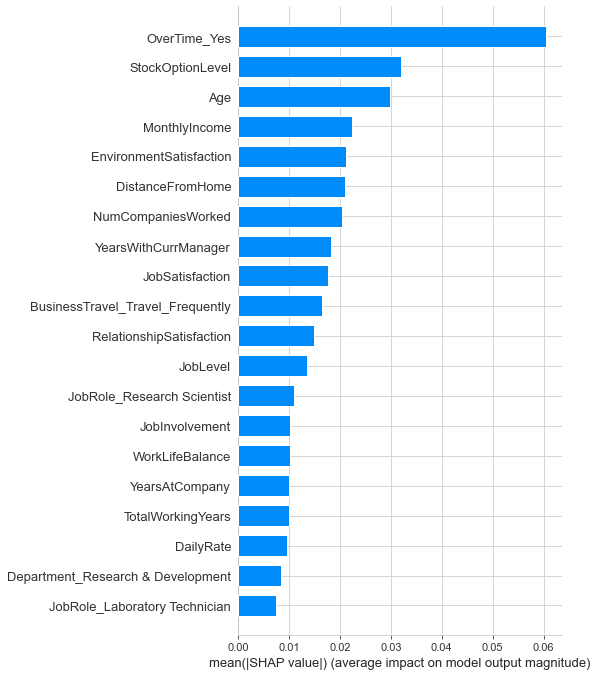

In [10]:
shap.summary_plot(shap_values[1], X_test.values, plot_type="bar", class_names= [1], feature_names = X_test.columns)

Due to computation limitation, the Shap explainer use only 20 values so we should take that intpo consideration.
Here we see that the most important variable is overtime. leading to employee attrition.

## 6.13.2- SHAP value impact on model summary plot
<a id='cell_6_13_2'></a>

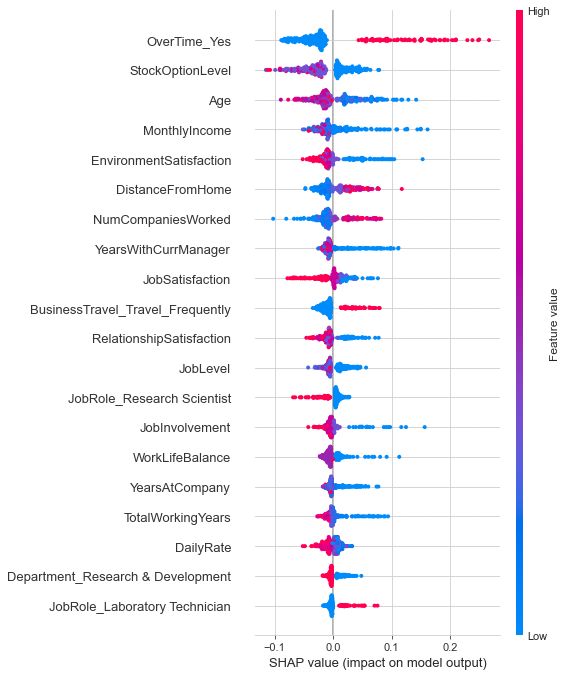

In [14]:
shap.summary_plot(shap_values[1], X_test.values, feature_names = X_test.columns)

here we see how the values are despersed and how they affect the probablity of attrition.
The sepration in the color of each row, shows that the model is finding a pattern in the data.
while when the coors are mixed, it is a sign that the model is finding different results.

### 6.13.3- SHAP dependence plot
<a id='cell_6_13_3'></a>

additinal information of the plot function can be found in the following link:
https://slundberg.github.io/shap/notebooks/plots/dependence_plot.html

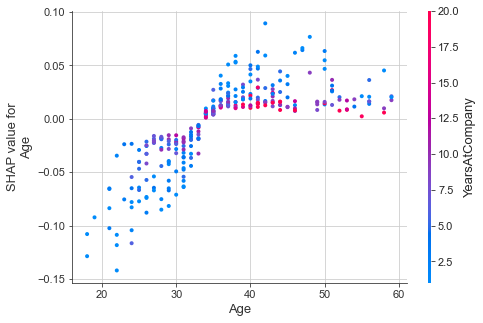

In [78]:
shap.dependence_plot('Age', shap_values[0], X_test.values, feature_names=X_test.columns)

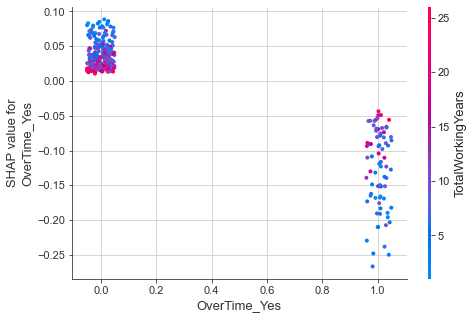

In [79]:
shap.dependence_plot('OverTime_Yes', shap_values[0], X_test.values, x_jitter= .1 , feature_names=X_test.columns)

jitter for categorical data

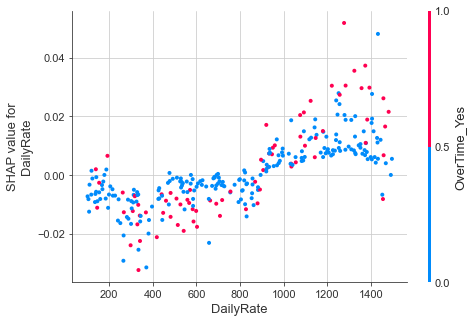

In [36]:
shap.dependence_plot('DailyRate', shap_values[0], X_test.values, feature_names=X_test.columns)

In the above plot we see that the variable daily rate has a relatively upward distribution  however there is a step at the the right end and the probabilty of attrition increses with higher daily rates.

If the variable has a high correlation with another variable, the dependence plot will add that variable automatically to the right axis, but as we can see in the following table, nihter the shap correlation nor the raw test data correlation is the max for the Overtime_Yes variable.

In [37]:
shap_df.corr()['DailyRate'].sort_values(ascending=False)

features
DailyRate                            1.000000
EmployeeNumber                       0.167345
TrainingTimesLastYear                0.165703
Education                            0.149345
EducationField_Medical               0.127995
JobRole_Sales Executive              0.127201
MaritalStatus_Divorced               0.120275
EducationField_Other                 0.117309
Department_Sales                     0.107377
Department_Research & Development    0.100035
DistanceFromHome                     0.088921
EducationField_Marketing             0.083128
JobRole_Research Scientist           0.073900
MaritalStatus_Single                 0.065513
WorkLifeBalance                      0.062108
RelationshipSatisfaction             0.060947
MonthlyRate                          0.042546
JobRole_Research Director            0.041332
JobSatisfaction                      0.027598
EnvironmentSatisfaction              0.025046
YearsSinceLastPromotion              0.024194
JobRole_Sales Representat

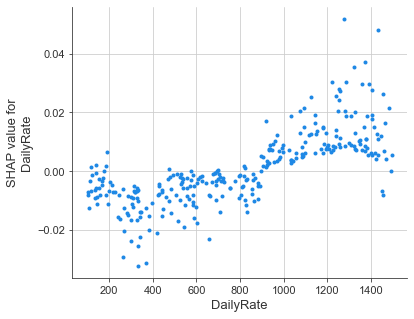

In [38]:
shap.dependence_plot('DailyRate', shap_values[0], X_test.values, feature_names=X_test.columns, interaction_index=None)

## 6.13.4- Individual Inspection and Analysis of errors with SHAP
<a id='cell_6_13_4'></a>

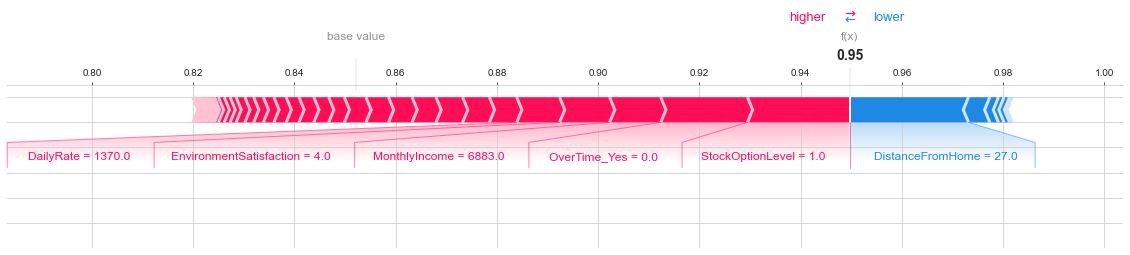

In [40]:
i=8
shap.force_plot(explainer.expected_value[0], shap_values[0][i], X_test.values[i], feature_names = X_test.columns, matplotlib= True)

we order observations by loss to see where the model is doing poorley.

In [41]:
predictions = pd.DataFrame(stack.predict(X_test), columns=["predictions"])

In [42]:
prob_pred = pd.DataFrame(stack.predict_proba(X_test), columns=["out_0", "out_1"])

In [43]:
loss_df = pd.concat([y_test, predictions, prob_pred], axis=1)

In [44]:
loss_df.columns = ["actual", "predictions", "out_0", "out_1"]

In [46]:
# difining loss column fuunctin
def log_loss_map(df):
    if df['actual'] == df['predictions']:
        return 0
    elif df['actual'] == 0:
        return df['out_1']
    elif df['actual'] == 1:
        return df['out_0']

In [47]:
loss_df['loss'] = loss_df.apply(log_loss_map, axis=1)

In [48]:
loss_df.sort_values(by = 'loss', ascending=False)

,actual,predictions,out_0,out_1,loss
240,1,0,0.950125,0.049875,0.950125
29,1,0,0.949230,0.050770,0.949230
87,1,0,0.945218,0.054782,0.945218
97,1,0,0.943313,0.056687,0.943313
162,1,0,0.939284,0.060716,0.939284
...,...,...,...,...,...
109,0,0,0.946755,0.053245,0.000000
110,0,0,0.910609,0.089391,0.000000
111,0,0,0.852926,0.147074,0.000000
112,0,0,0.905191,0.094809,0.000000


In [49]:
dill.dump(loss_df, open("loss_df.pkl", "wb"))

In [ ]:
loss_df = dill.load(open("loss_df.pkl", "rb"))

now we run a foor loop to get the 10 observations with worst probability predictions.

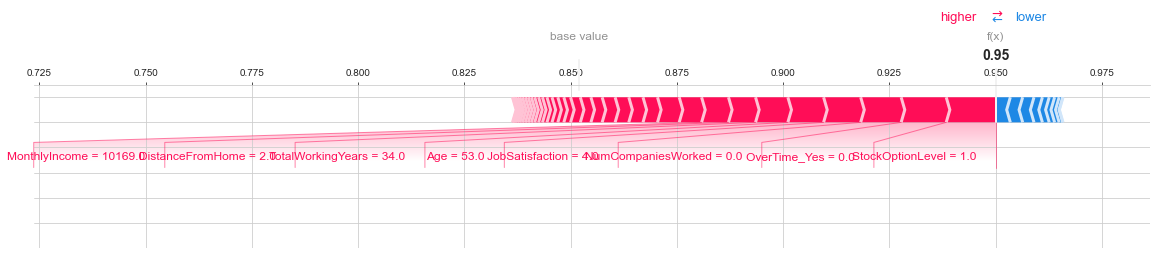

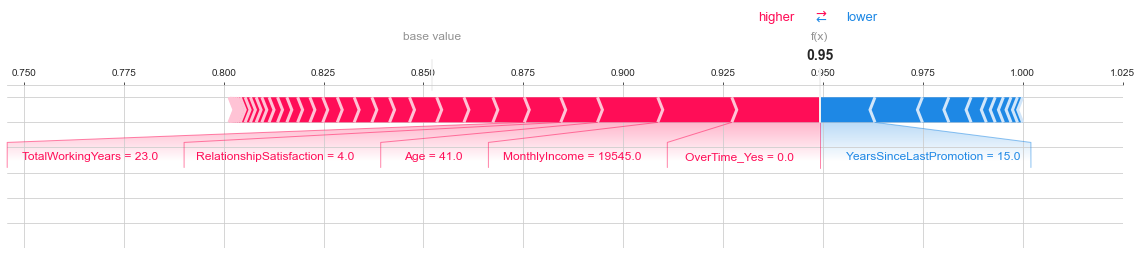

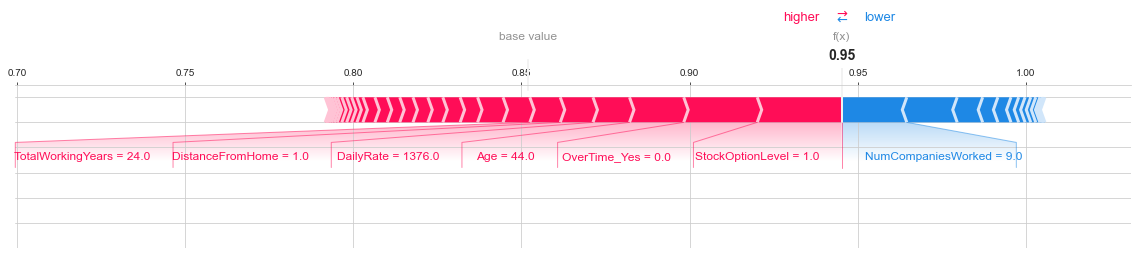

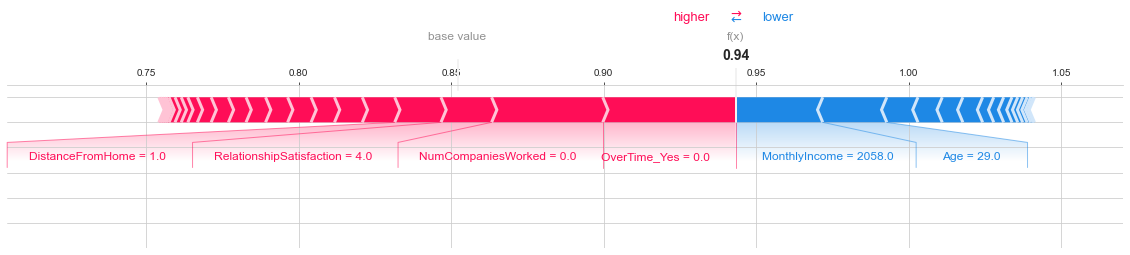

In [60]:
for i in loss_df['loss'].sort_values(ascending=False).index[:4]:
    shap.force_plot(explainer.expected_value[0], shap_values[0][i], X_test.values[i], feature_names = X_test.columns, matplotlib= True)

- what wee see in analysing the errors is that, the model mostly fails in predicting those who are going to leave the company, and the top contributer to that problem is stockOptionlevel in the errors that we have investigated.
- However we can not edit our models based on the erros we see on the test as it might lead to overfitting.
- We can use training data and see how might removing or reducing weight of certain column can help the model.
- As the project is alread very long I am going to leave it for anothyer project.


Many of the shap methods are not availabe to kernel method which is needed to analyse stacked models.
Hence I am going to use a single tree model in the following plots.

## 6.13.5- SHAP Decisionplot
<a id='cell_6_13_5'></a>

Another nice graph for shap values, however the graph can become very cluttered if too many observations are included. We can use it to summarise the force plots that we had in the previous section.

In [61]:
highest_errors = loss_df['loss'].sort_values(ascending=False).index[:5]

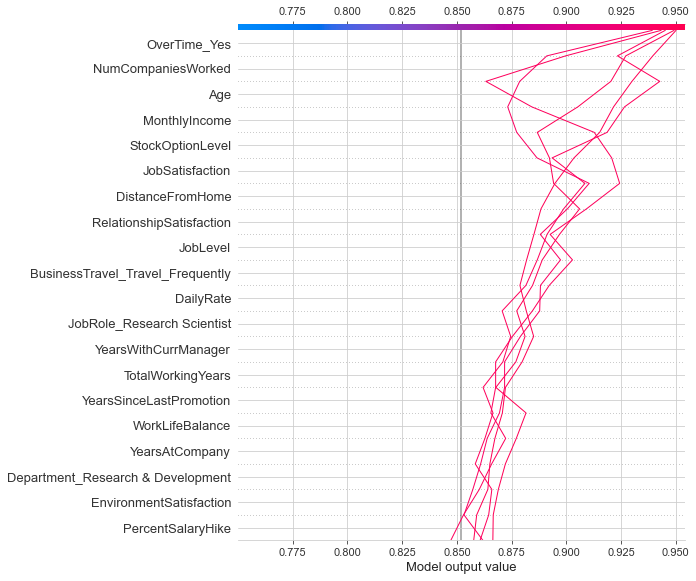

In [115]:
shap.decision_plot(explainer.expected_value[0], shap_values[0][highest_errors], X_test)

It seems that the model fails to predict appropriate probability for the listed observations because it is not able to give the correct weight to overtime feature.
If someone is going to leave the company and that person is staying overtime, the model gives more weight to probability of stay.
It is a good starting point why model is behaving so for this particular observations. There is the probability of data being imbalanced. At the moment I am not aware what is the best method to adress this issue. And I will look into it future projects.

In [ ]:
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

## 6.13.6- SHAP Interaction
<a id='cell_6_13_6'></a>

Many of the plots can not be drawn using Kernel Explainer as the package is currently being developed. Hence I am going to use an XGBoost model.

In [85]:
opt_xgb = dill.load(open("opt_xgb.p", "rb"))

https://towardsdatascience.com/analysing-interactions-with-shap-8c4a2bc11c2a
https://h1ros.github.io/posts/explain-the-interaction-values-by-shap/
I used the above links as the refrence for this part.

In [116]:
# Create object that can calculate shap values
tree_explainer = shap.TreeExplainer(opt_xgb)
# Calculate Shap values
tree_shap_values = tree_explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [125]:
#Get SHAP interaction values
tree_shap_interaction = tree_explainer.shap_interaction_values(X_test)

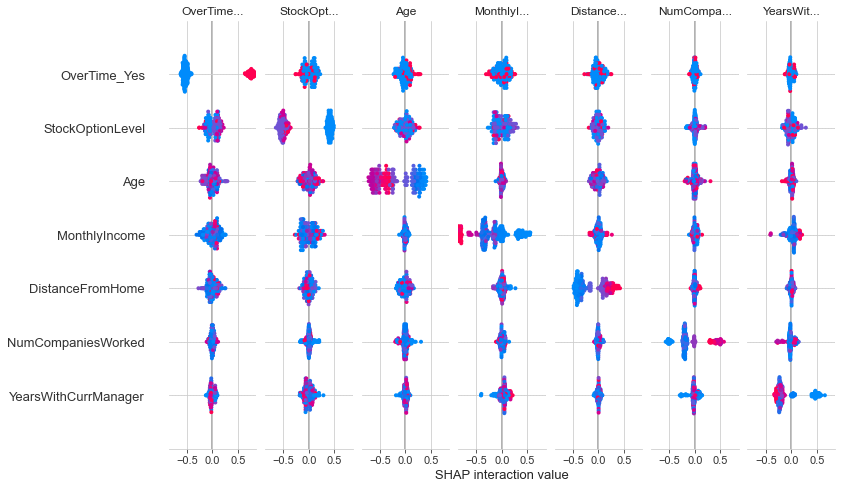

In [126]:
shap.summary_plot(tree_shap_interaction, X_test)

At the moment I can't interpret the graph, I don't know on each axis what is shown and there is no legend.
My guess is that the X axis is representative of shap value and the color is representive of features on X axis. The distance fro the horisontal line is the value for the feature on the Y axis.
If one needs to study the effects of interaction, I think it is better to use the dependence plot.

In [121]:
# SHAP interaction values for first employee
interaction_matrix = pd.DataFrame(tree_shap_interaction[0],index=X_train.columns,columns=X_train.columns)
interaction_matrix

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y,OverTime_Yes
Age,0.351837,-0.014455,-0.021666,-0.009857,0.0,-0.004126,0.006165,0.000643,-0.000009,0.005582,...,0.000000,0.0,0.006666,0.008465,-0.016142,-0.000057,0.001374,0.000734,0.0,-0.010442
DailyRate,-0.014455,0.015774,0.007141,-0.029587,0.0,0.012789,0.000246,0.003471,0.006501,0.007614,...,-0.000510,0.0,0.004345,0.000034,0.003081,0.000000,0.001714,0.003596,0.0,-0.024077
DistanceFromHome,-0.021666,0.007141,0.145652,-0.009682,0.0,0.005648,-0.014749,-0.003431,0.001660,-0.003426,...,0.000000,0.0,0.001231,-0.002600,-0.007344,0.000000,-0.001229,0.005582,0.0,0.002937
Education,-0.009857,-0.029587,-0.009682,-0.078955,0.0,0.003186,0.012039,0.015059,-0.004770,-0.000771,...,0.000000,0.0,0.001063,0.000249,0.000000,0.000000,0.001816,0.000388,0.0,-0.009267
EmployeeCount,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
EmployeeNumber,-0.004126,0.012789,0.005648,0.003186,0.0,0.032995,-0.007999,-0.002502,0.001163,0.001820,...,-0.000075,0.0,-0.000177,0.000438,-0.011299,-0.000201,-0.000498,0.000139,0.0,0.009271
EnvironmentSatisfaction,0.006165,0.000246,-0.014749,0.012039,0.0,-0.007999,-0.332143,-0.002605,0.001484,0.011671,...,0.000000,0.0,-0.002385,-0.003720,0.040100,0.000000,0.000000,-0.000594,0.0,-0.010654
HourlyRate,0.000643,0.003471,-0.003431,0.015059,0.0,-0.002502,-0.002605,-0.328415,-0.007293,0.002215,...,0.000000,0.0,0.001014,0.003516,0.013025,0.000000,0.002519,0.000043,0.0,-0.024013
JobInvolvement,-0.000009,0.006501,0.001660,-0.004770,0.0,0.001163,0.001484,-0.007293,-0.080806,0.000247,...,-0.000045,0.0,0.000872,-0.000047,0.004575,0.000000,-0.000447,0.000733,0.0,-0.010419
JobLevel,0.005582,0.007614,-0.003426,-0.000771,0.0,0.001820,0.011671,0.002215,0.000247,0.113161,...,0.000000,0.0,0.000763,0.013397,0.000000,0.000000,-0.000066,0.000000,0.0,-0.046237


The matrix tells us how much each factor contributed to the model's prediction when compared to the mean prediction. This is a similar interpretation to standard SHAP values except the contributions are broken down into main and interaction effects.

<AxesSubplot:>

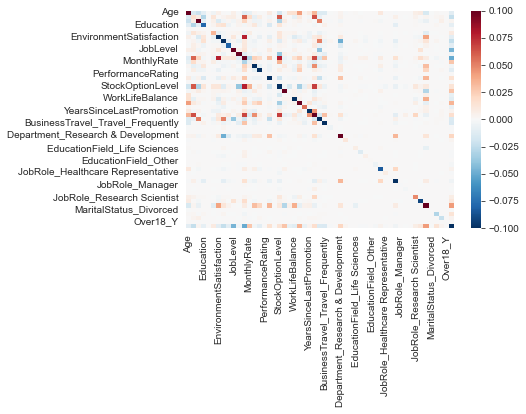

In [122]:
sns.heatmap(interaction_matrix, cmap='RdBu_r', vmin=-0.1, vmax=0.1)

The graph could be helpful when analysing errors.

In [ ]:
dill.dump(tree_explainer, open("tree_explainer.p", "wb"))
dill.dump(tree_shap_values, open("tree_shap_values.p", "wb"))

In [ ]:
tree_explainer = dill.load(open("tree_explainer.p", "rb"))
tree_shap_values = dill.load(open("tree_shap_values.p", "rb"))

## 6.13.7- Shap waterfall
<a id='cell_6_13_7'></a>

There is an open github issue for the waterfall plot, it is not working.
https://github.com/slundberg/shap/issues/1420

In [137]:
tree_explainer = shap.Explainer(opt_xgb, X_test)
tree_shap_values = tree_explainer(X_test)

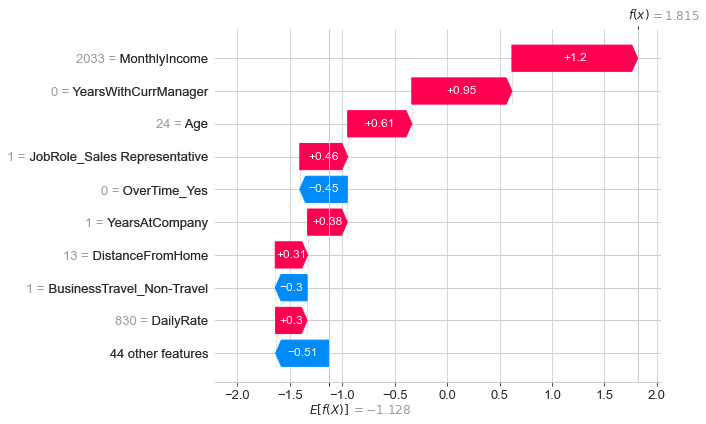

In [139]:
shap.plots.waterfall(tree_shap_values[0])

Here we can investigate a readable view of a certain observation and how model is weighting each feature.

## 6.13.8- SHAP heatmap
<a id='cell_6_13_8'></a>

In [135]:
tree_explainer = shap.Explainer(opt_xgb, X_test)
tree_shap_values = tree_explainer(X_test)

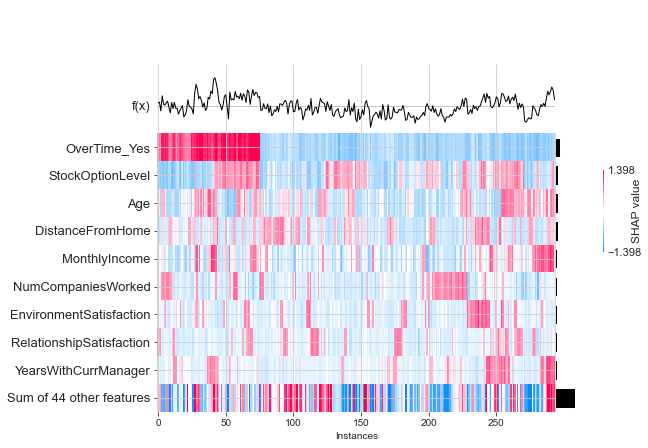

In [136]:
shap.plots.heatmap(tree_shap_values)

## 6.13.9- Partial correlation with shap values - ParShap
<a id='cell_6_13_9'></a>

- https://towardsdatascience.com/which-of-your-features-are-overfitting-c46d0762e769
- When predictions are good on training data but bad on test data, it is said that the model is “overfitting”. It means that the model has learnt too many noisy patterns from training data, and so it’s unable to generalize well to data it has not seen before.
- We can use shap to find columns that are causing overfitting.

In [ ]:
explainer = shap.KernelExplainer(stack.predict_proba, shap.sample(X_train,10))
shap_values = explainer.shap_values(X_train)
shap_df_train = pd.DataFrame(shap_values[0], columns=pd.Index(X_train.columns, name='features'))

In [ ]:
explainer = shap.KernelExplainer(stack.predict_proba, shap.sample(X_test,10))
shap_values = explainer.shap_values(X_test)
shap_df_test = pd.DataFrame(shap_values[0], columns=pd.Index(X_test.columns, name='features'))

In [147]:
dill.dump(shap_df_train, open("shap_df_train.p", "wb"))
dill.dump(shap_df_test, open("shap_df_test.p", "wb"))

In [ ]:
shap_df_train = dill.load(open("shap_df_train.p", "rb"))
shap_df_test = dill.load(open("shap_df_test.p", "rb"))

In [151]:
import pingouin

In [154]:
pingouin.partial_corr(
    data = pd.concat([shap_df_test, y_test], axis = 1).astype(float),
    x = 'Age',
    y = 'Attrition',
    x_covar = [feature for feature in shap_df_test.columns if feature != 'Age']
)

divide by zero encountered in true_divide
invalid value encountered in matmul
invalid value encountered in true_divide


,n,r,CI95%,p-val
pearson,294,-0.035958,"[-0.16, 0.09]",0.577765


In [162]:
def partial_correlation(X, y):
    out = pd.Series(index = X.columns, dtype = float)
    for feature_name in X.columns:
        out[feature_name] = partial_corr(
            data = pd.concat([X, y], axis = 1).astype(float),
            x = feature_name,
            y = y.columns,
            x_covar = [f for f in X.columns if f != feature_name]
        ).loc['pearson', 'r']
    return out

In [ ]:
parshap_train = partial_correlation(shap_df_train, y_train)
parshap_test = partial_correlation(shap_df_test, y_test)

In [ ]:
parshap_diff = parshap_test - parshap_train
parshap_diff.reindex(parshap_diff.abs().sort_values(ascending=False).index)

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


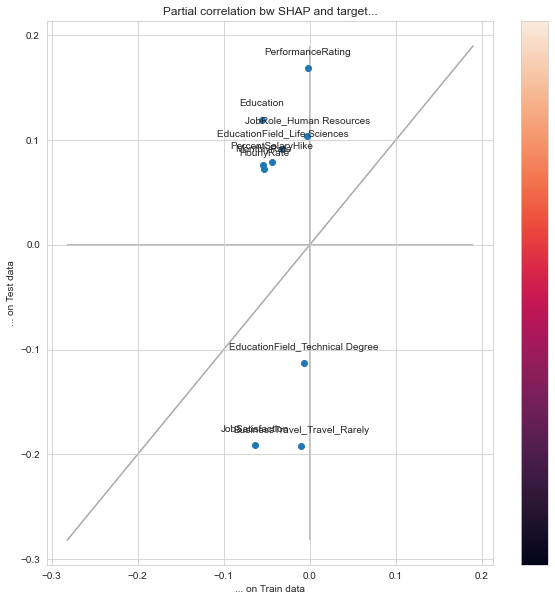

In [180]:
selected_features = parshap_diff.abs().sort_values(ascending=False).index[:10]
# Plot parshap
plotmin, plotmax = min(parshap_train.min(), parshap_test.min()), max(parshap_train.max(), parshap_test.max())
plotbuffer = .05 * (plotmax - plotmin)
fig, ax = plt.subplots(figsize=(10,10))
if plotmin < 0:
    ax.vlines(0, plotmin - plotbuffer, plotmax + plotbuffer, color = 'darkgrey', zorder = 0)
    ax.hlines(0, plotmin - plotbuffer, plotmax + plotbuffer, color = 'darkgrey', zorder = 0)
ax.plot(
    [plotmin - plotbuffer, plotmax + plotbuffer], [plotmin - plotbuffer, plotmax + plotbuffer],
    color = 'darkgrey', zorder = 0
)

sc = ax.scatter(
    parshap_train[selected_features], parshap_test[selected_features],)
 #   edgecolor = 'grey', c = fimpo, s = 50, cmap = plt.cm.get_cmap('Reds'), vmin = 0, vmax = fimpo.max())
ax.set(title = 'Partial correlation bw SHAP and target...', xlabel = '... on Train data', ylabel = '... on Test data')
cbar = fig.colorbar(sc)
cbar.set_ticks([])
for txt in parshap_train[selected_features].index:
    ax.annotate(txt, (parshap_train[txt], parshap_test[txt] + plotbuffer / 2), ha = 'center', va = 'bottom')
fig.show()

If a feature lies on the bisector, it means it performs exactly the same on train set and on test set. It’s the ideal situation, when there is neither overfitting nor underfitting. On the contrary, if a feature lies below the bisector, it means it has performed worse on test set than it did on training set. This is the overfitting area.

In general, ParShap should not be used as a method for feature selection. Indeed, the fact that some features are prone to overfitting does not imply that those features don’t carry useful information at all! (For instance, income and age, in this example).

# to be continued...

## Does the features affect the predictions as expected?
https://www.youtube.com/watch?v=0yXtdkIL3Xk

One of the main usages of machine learning explanabilty is to see if the model is working as expected.
For example does incositent behavior lead to model predicting more fraud? Or does higher age mean higher chance of cancer.

In [ ]:
## SHAP Explanation
https://towardsdatascience.com/black-box-models-are-actually-more-explainable-than-a-logistic-regression-f263c22795d
https://towardsdatascience.com/shap-explained-the-way-i-wish-someone-explained-it-to-me-ab81cc69ef30